In [1]:
# Importando librerias
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from __future__ import print_function, division
from PyAstronomy import pyasl
from astropy.timeseries import LombScargle
from specutils import Spectrum1D
from astropy.io import fits as pyfits
from astropy.io import fits
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import astropy.units as u
import seaborn as sns
import pandas as pd
import numpy as np
import specutils.io
import scipy as sc
from scipy.stats import norm
import csv
import os
import sys
from scipy.stats import kstest
from scipy.stats import ks_2samp
import math
from scipy import stats

## Espectros de Danilo

In [2]:
#%pip install PyAstronomy

In [3]:
print(dir(specutils.io))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'custom_writer', 'data_loader', 'default_loaders', 'get_loaders_by_extension', 'identify_spectrum_format', 'parsing_utils', 'registers']


In [4]:
"""from specutils import Spectrum1D
spec = Spectrum1D.read('mymultispec.fits', format='fits', hdu=1, fill_value='nan')
print(spec)"""

"from specutils import Spectrum1D\nspec = Spectrum1D.read('mymultispec.fits', format='fits', hdu=1, fill_value='nan')\nprint(spec)"

In [5]:
Espectros = ['2022-02-06_s-rich_av_vac.fits','2022-03-12_s-rich_av_vac.fits','2022-03-18_s-rich_av_vac.fits','2022-03-19_s-rich_av_vac.fits','2022-03-20_s-rich_av_vac.fits','2022-03-23_s-rich_av_vac.fits', '2022-03-26_s-rich_av_vac.fits', '2022-03-28_s-rich_av_vac.fits']
srich1 = fits.open(Espectros[7])

In [6]:
srich1.info()

Filename: 2022-03-28_s-rich_av_vac.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      71   (66462,)   float32   


In [7]:
srich1[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                66462 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2023-12-04T20:07:30' / Date FITS file was generated                  
IRAF-TLM= '2023-12-04T20:07:30' / Time of last modification                     
WCSDIM  =                    2                                                  
CTYPE1  = 'MULTISPE'                                                            
CDELT1  =                   1.                                                  
CD1_1   =                   1.                                                  
LTM1_1  =                   

In [8]:
srich1[0].header['WAT2_001']

'wtype=multispec spec1 = "1 1 2 4325.12361881 0.041374720270844 66462'

In [9]:
inicio = float(srich1[0].header['WAT2_001'][31:45])
paso = float(srich1[0].header['WAT2_001'][46:63])

print(inicio, paso)

4325.12361881 0.041374720270844


In [10]:
srich1[0].data

array([0.5762266 , 1.038174  , 0.7128054 , ..., 1.037714  , 1.0037628 ,
       0.99021554], dtype='>f4')

Para sacar las longitudes de onda, me guíe por esta: https://lotharschanne.wordpress.com/spectro-python/introduction-of-a-first-spectroscopic-program/

In [11]:
flux = np.array(srich1[0].data)
wave = np.ones(srich1[0].header['NAXIS1'], dtype=float)
for i in range(srich1[0].header['NAXIS1']):
    wave[i] = inicio + i*paso #srich1[0].header['CDELT1']

In [12]:
flux

array([0.5762266 , 1.038174  , 0.7128054 , ..., 1.037714  , 1.0037628 ,
       0.99021554], dtype='>f4')

In [13]:
wave

array([4325.12361881, 4325.16499353, 4325.20636825, ..., 7074.84615329,
       7074.88752801, 7074.92890273])

In [14]:
len(wave),len(flux)

(66462, 66462)

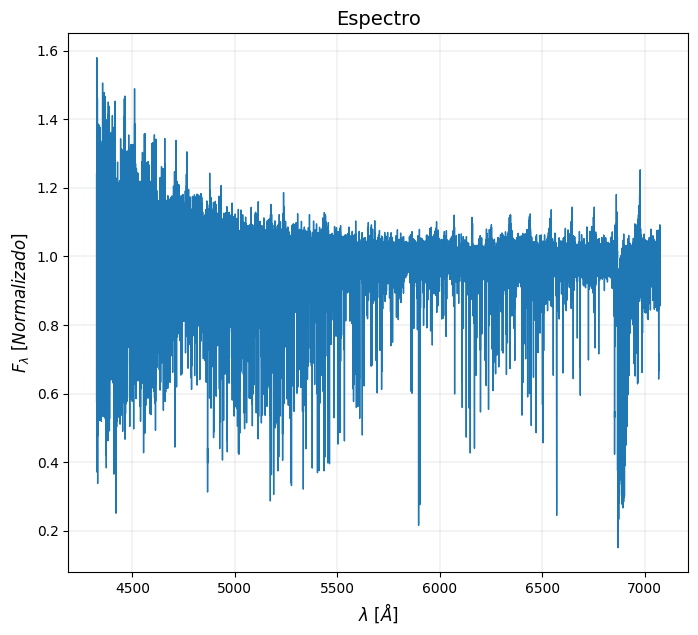

In [15]:
plt.figure(figsize=(8,7))
plt.plot(wave,flux, '-',linewidth = 1)

plt.xlabel('$\lambda~ [Å]$',fontsize = 12)
plt.ylabel('$F_\lambda~  [Normalizado]$' ,fontsize = 12)
plt.title("Espectro",fontsize = 14)
#plt.xlim(4000,4450)
plt.grid(linestyle='-', linewidth=0.2)

In [16]:
TablaIspec = pd.DataFrame()
TablaIspec["waveobs"] = wave
TablaIspec["flux"] = flux.byteswap().view(flux.dtype.newbyteorder()) 
TablaIspec["err"] = [0]*len(wave)
TablaIspec

,waveobs,flux,err
0,4325.123619,0.576227,0
1,4325.164994,1.038174,0
2,4325.206368,0.712805,0
3,4325.247743,0.765901,0
4,4325.289118,1.241851,0
...,...,...,...
66457,7074.763404,0.954291,0
66458,7074.804779,1.035486,0
66459,7074.846153,1.037714,0
66460,7074.887528,1.003763,0


In [17]:
def Extraccion_Espectros(x, nombre):
    print(x)
    srich1 = fits.open(x)
    flux = np.array(srich1[0].data)
    wave = np.ones(srich1[0].header['NAXIS1'], dtype=float)
    
    inicio = float(srich1[0].header['WAT2_001'][31:46])
    paso = float(srich1[0].header['WAT2_001'][47:63])

    for i in range(srich1[0].header['NAXIS1']):
        wave[i] = inicio + i*paso

    plt.figure(figsize=(8,7))
    plt.plot(wave,flux, '-',linewidth = 0.8,color='k') 
    plt.xlabel('$\lambda~ [Å]$',fontsize = 12)
    plt.ylabel('$F_\lambda~  [Normalizado]$' ,fontsize = 12)
    plt.title(nombre,fontsize = 14)
    plt.grid(linestyle='-', linewidth=0.2)
    
    TablaIspec = pd.DataFrame()
    TablaIspec['waveobs'] = wave
    TablaIspec['flux'] = flux.byteswap().view(flux.dtype.newbyteorder()) 
    TablaIspec['err'] = [0]*len(wave)
    
    TablaIspec.to_csv(nombre+".txt", sep=" ", quoting=csv.QUOTE_NONE, escapechar=" ", index = False)

2022-02-06_s-rich_av_vac.fits


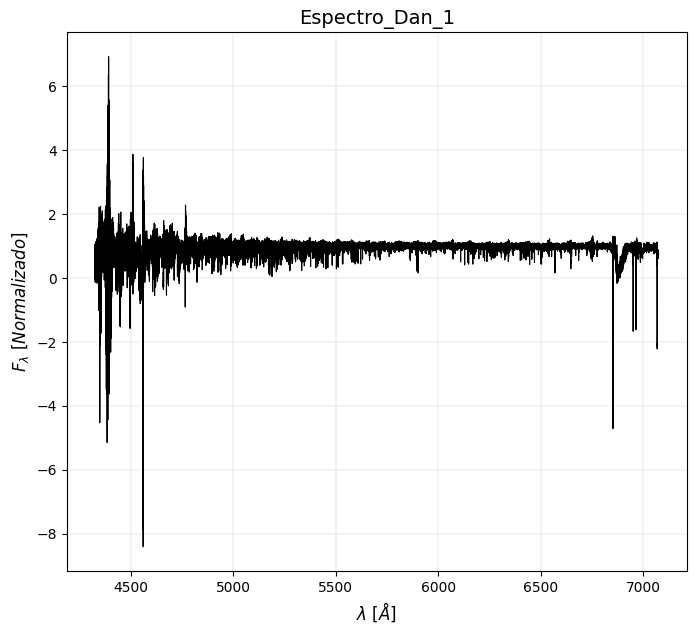

In [18]:
Extraccion_Espectros(Espectros[0],'Espectro_Dan_1')

2022-03-12_s-rich_av_vac.fits


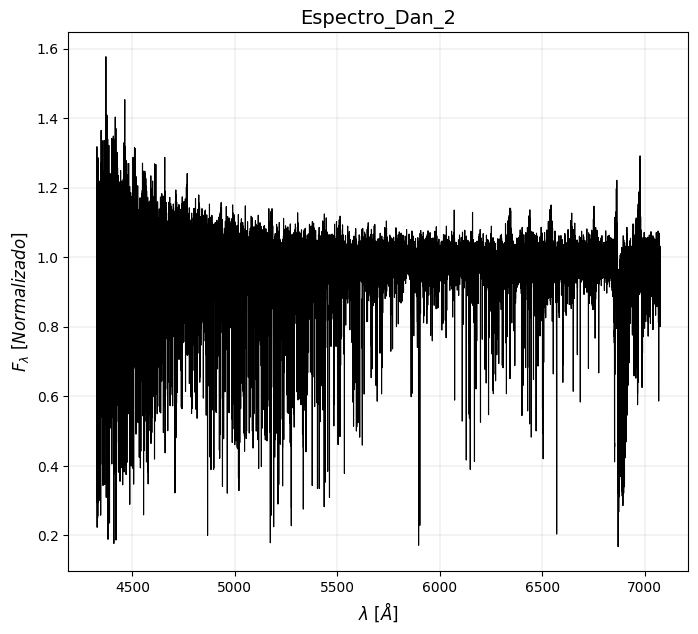

In [19]:
Extraccion_Espectros(Espectros[1],'Espectro_Dan_2')

2022-03-18_s-rich_av_vac.fits


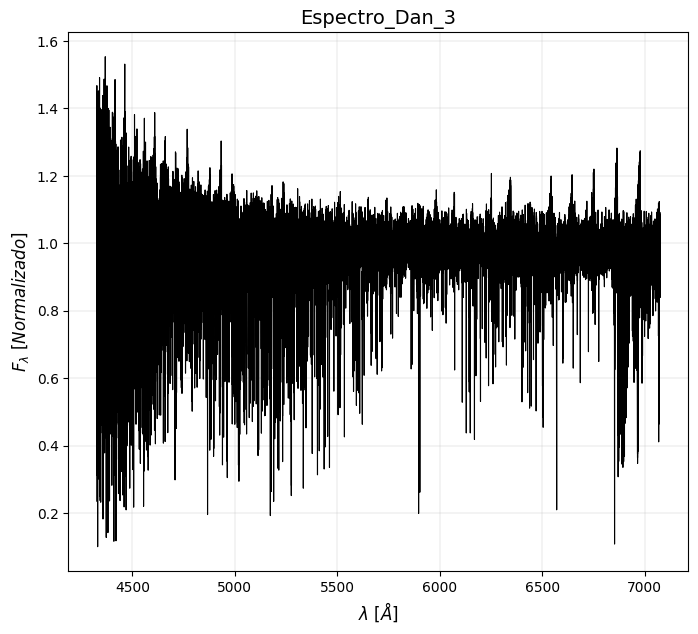

In [20]:
Extraccion_Espectros(Espectros[2],'Espectro_Dan_3')

2022-03-19_s-rich_av_vac.fits


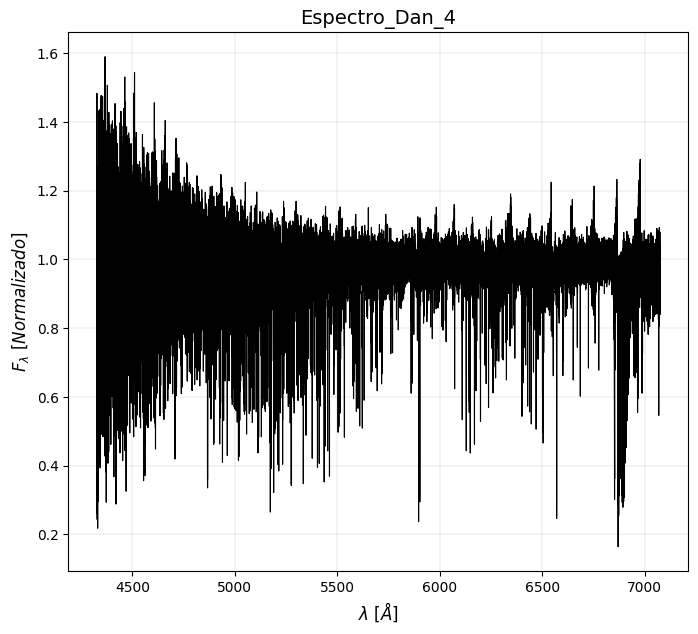

In [21]:
Extraccion_Espectros(Espectros[3],'Espectro_Dan_4')

2022-03-20_s-rich_av_vac.fits


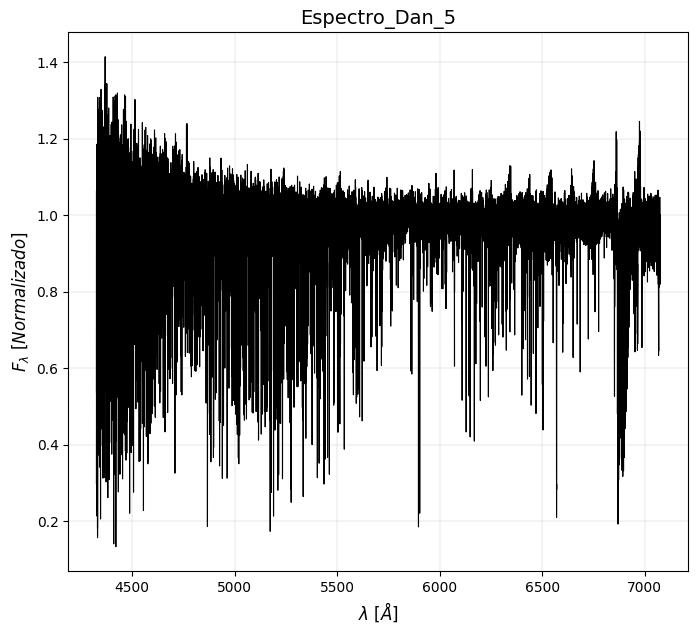

In [22]:
Extraccion_Espectros(Espectros[4],'Espectro_Dan_5')

2022-03-23_s-rich_av_vac.fits


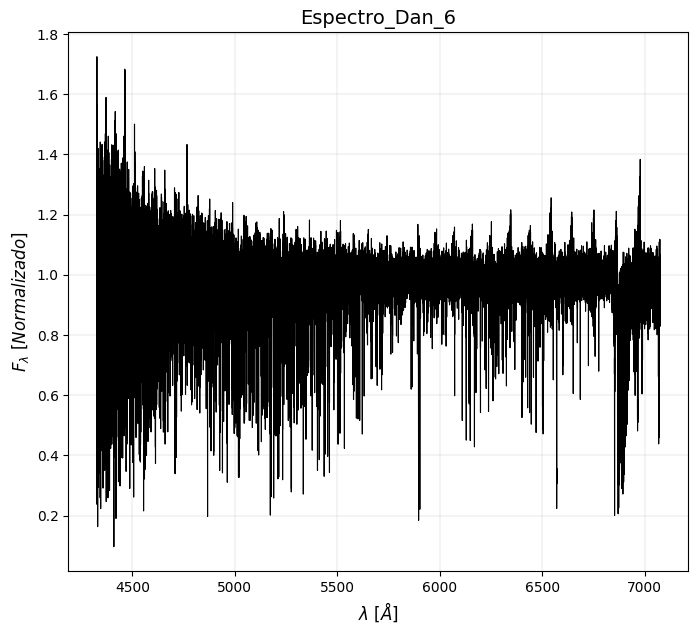

In [23]:
Extraccion_Espectros(Espectros[5],'Espectro_Dan_6')

2022-03-26_s-rich_av_vac.fits


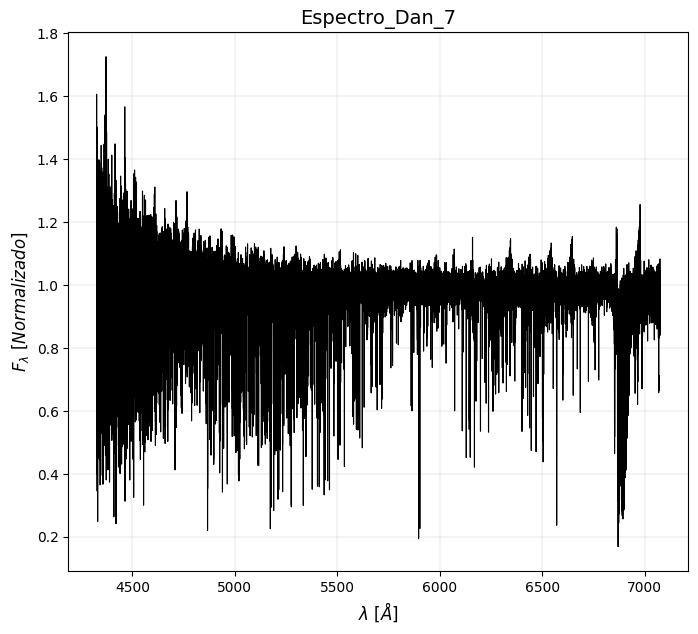

In [24]:
Extraccion_Espectros(Espectros[6],'Espectro_Dan_7')

In [25]:
def Extraccion_UltimoEspectros(x, nombre):
    print(x)
    srich1 = fits.open(x)
    flux = np.array(srich1[0].data)
    wave = np.ones(srich1[0].header['NAXIS1'], dtype=float)
    
    inicio = float(srich1[0].header['WAT2_001'][31:45])
    paso = float(srich1[0].header['WAT2_001'][46:63])

    for i in range(srich1[0].header['NAXIS1']):
        wave[i] = inicio + i*paso

    plt.figure(figsize=(8,7))
    plt.plot(wave,flux, '-',linewidth = 0.8,color='k') 
    plt.xlabel('$\lambda~ [Å]$',fontsize = 12)
    plt.ylabel('$F_\lambda~  [Normalizado]$' ,fontsize = 12)
    plt.title(nombre,fontsize = 14)
    plt.grid(linestyle='-', linewidth=0.2)
    
    TablaIspec = pd.DataFrame()
    TablaIspec['waveobs'] = wave
    TablaIspec['flux'] = flux.byteswap().view(flux.dtype.newbyteorder()) 
    TablaIspec['err'] = [0]*len(wave)
    
    TablaIspec.to_csv(nombre+".txt", sep=" ", quoting=csv.QUOTE_NONE, escapechar=" ", index = False)


2022-03-28_s-rich_av_vac.fits


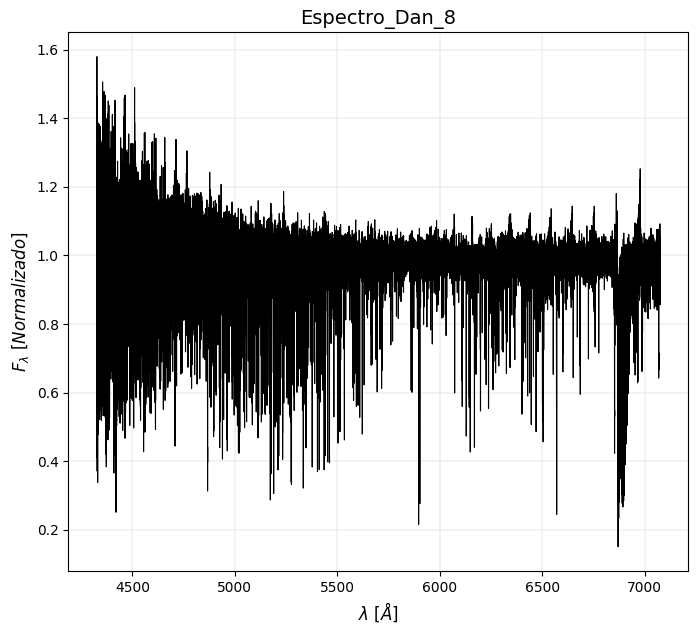

In [26]:
Extraccion_UltimoEspectros(Espectros[7],'Espectro_Dan_8')

In [27]:
Espectros = ['2022-02-06_s-rich.dat','2022-03-12_s-rich.dat','2022-03-18_s-rich.dat','2022-03-19_s-rich.dat','2022-03-20_s-rich.dat','2022-03-23_s-rich.dat','2022-03-26_s-rich.dat','2022-03-28_s-rich.dat']
def Archivo_txt(x, nombre):
    print(x)
    df = pd.read_csv('Espectros Danilo .dat/'+x, sep = '\s+', header=None)
    df = df.set_axis(['waveobs','flux'], axis=1)
    df['err'] = [0]*len(df['flux'] )
    df.to_csv(nombre+".txt", sep=" ", quoting=csv.QUOTE_NONE, escapechar=" ", index = False)

In [28]:
Archivo_txt(Espectros[0],'Espectros_Dan_Ult1')
Archivo_txt(Espectros[1],'Espectros_Dan_Ult2')
Archivo_txt(Espectros[2],'Espectros_Dan_Ult3')
Archivo_txt(Espectros[3],'Espectros_Dan_Ult4')
Archivo_txt(Espectros[4],'Espectros_Dan_Ult5')
Archivo_txt(Espectros[5],'Espectros_Dan_Ult6')
Archivo_txt(Espectros[6],'Espectros_Dan_Ult7')
Archivo_txt(Espectros[7],'Espectros_Dan_Ult8')

2022-02-06_s-rich.dat
2022-03-12_s-rich.dat
2022-03-18_s-rich.dat
2022-03-19_s-rich.dat
2022-03-20_s-rich.dat
2022-03-23_s-rich.dat
2022-03-26_s-rich.dat
2022-03-28_s-rich.dat


In [29]:
# Definir una función que aplica estilos a columnas específicas con colores diferentes
def resaltar_columnas(s, colores):
    return ['background-color: {}'.format(colores.get(col, '')) for col in s.index]

In [30]:
TablaVR_DanUlt = pd.DataFrame()
VR_DanUlt = [315.79,315.55, 315.46, 315.43, 315.58,315.52, 315.57, 315.54]
Err_VR_DanUlt = [0.03,0.03, 0.03, 0.04, 0.03, 0.04, 0.04, 0.04]

Fecha = ["2022-02-06","2022-03-12","2022-03-18","2022-03-19","2022-03-20","2022-03-23","2022-03-26","2022-03-28"]
Fecha_Juliana = [59616.23, 59650.1,  59656.05, 59657.12, 59658.06, 59661.1,  59664.12, 59666.12]
TablaVR_DanUlt['Fecha (MJD)'] =  np.around(Fecha_Juliana,2)
TablaVR_DanUlt['VR (km/s)'] = VR_DanUlt
TablaVR_DanUlt['Err_VR (km/s)'] = Err_VR_DanUlt
TablaVR_DanUlt = TablaVR_DanUlt.round(2)  # 2 decimales

# Especificar los colores para cada columna
colores_resaltar = {'VR (km/s)': '#ffb563',  'Err_VR (km/s)': '#ffd29d'}

# Aplicar estilos al DataFrame
estilos = TablaVR_DanUlt.style.apply(lambda x: resaltar_columnas(x, colores_resaltar), axis=1)

# Mostrar el DataFrame con los estilos aplicados
estilos

,Fecha (MJD),VR (km/s),Err_VR (km/s)
0,59616.230000,315.790000,0.030000
1,59650.100000,315.550000,0.030000
2,59656.050000,315.460000,0.030000
3,59657.120000,315.430000,0.040000
4,59658.060000,315.580000,0.030000
5,59661.100000,315.520000,0.040000
6,59664.120000,315.570000,0.040000
7,59666.120000,315.540000,0.040000


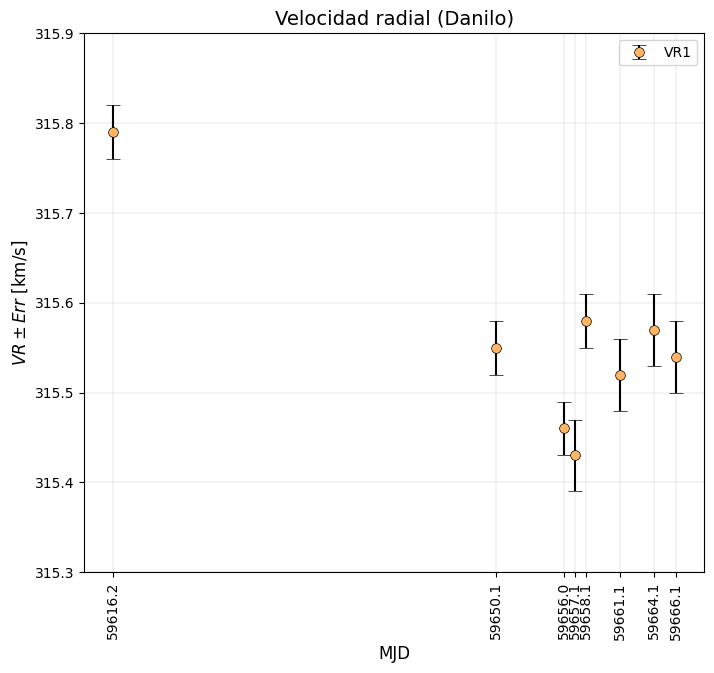

In [31]:
plt.figure(figsize=(8,7))
x = [-22,12,18,19,20,23,26,28]
plt.errorbar(x, VR_DanUlt,  yerr = Err_VR_DanUlt, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#ffb563',mec='k', ms=7, mew=0.5, label ='VR1')

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial (Danilo)',fontsize = 14)
plt.ylim(315.3,315.9)
plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 

## Resultados con el mismo inicio y paso para cada espectro

In [32]:
# Definir una función que aplica estilos a columnas específicas con colores diferentes
def resaltar_columnas(s, colores):
    return ['background-color: {}'.format(colores.get(col, '')) for col in s.index]

In [33]:
TablaVR = pd.DataFrame()
VR1 = [315.66, 321.46, 321.94, 339.60, 339.10, 323.13, 342.66, 344.77]
VR2 = [float('NaN'),338.21,338.11,322.24,322.49,344.00,323.49,323.76]
#VR3 = [float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN'),368.86]
VR_mean = [(VR1[i]+VR2[i])/2 for i in range(8)]
Err_VR1 = [0.05,0.25, 0.23, 0.34, 0.27, 0.31, 0.44, 0.55]
Err_VR2 = [0,0.27,0.24,0.37,0.27,0.71,0.34,0.47]
Err_VR_mean = [(Err_VR1[i]+Err_VR2[i])/2 for i in range(8)]

#Err_VR3 = [0,0,0,0,0,0,0,0.61]

Fecha = ["2022-02-06","2022-03-12","2022-03-18","2022-03-19","2022-03-20","2022-03-23","2022-03-26","2022-03-28"]
Fecha_Juliana = [59616.23, 59650.1,  59656.05, 59657.12, 59658.06, 59661.1,  59664.12, 59666.12]
TablaVR['Fecha (MJD)'] =  np.around(Fecha_Juliana,2)
TablaVR['VR1 (km/s)'] = VR1
TablaVR['VR1 Err (km/s)'] = Err_VR1
TablaVR['VR2 (km/s)'] = VR2
TablaVR['VR2 Err (km/s)'] = Err_VR2
#TablaVR['VR3 (km/s)'] = VR3
#TablaVR['VR3 Err (km/s)'] = Err_VR3
TablaVR['VR Mean (km/s)'] = VR_mean
TablaVR['VR Mean (km/s)'] = TablaVR['VR Mean (km/s)'].fillna(315.66)
TablaVR['VR Err Mean (km/s)'] = Err_VR_mean

#TablaVR

In [34]:
# Especificar los colores para cada columna
colores_resaltar = {'VR1 (km/s)': '#89B0AE', 'VR2 (km/s)': '#BEE3DB', 'VR Mean (km/s)':'#FFD6BA'}

# Aplicar estilos al DataFrame
estilos = TablaVR.style.apply(lambda x: resaltar_columnas(x, colores_resaltar), axis=1)

# Mostrar el DataFrame con los estilos aplicados
estilos

,Fecha (MJD),VR1 (km/s),VR1 Err (km/s),VR2 (km/s),VR2 Err (km/s),VR Mean (km/s),VR Err Mean (km/s)
0,59616.230000,315.660000,0.050000,nan,0.000000,315.660000,0.025000
1,59650.100000,321.460000,0.250000,338.210000,0.270000,329.835000,0.260000
2,59656.050000,321.940000,0.230000,338.110000,0.240000,330.025000,0.235000
3,59657.120000,339.600000,0.340000,322.240000,0.370000,330.920000,0.355000
4,59658.060000,339.100000,0.270000,322.490000,0.270000,330.795000,0.270000
5,59661.100000,323.130000,0.310000,344.000000,0.710000,333.565000,0.510000
6,59664.120000,342.660000,0.440000,323.490000,0.340000,333.075000,0.390000
7,59666.120000,344.770000,0.550000,323.760000,0.470000,334.265000,0.510000


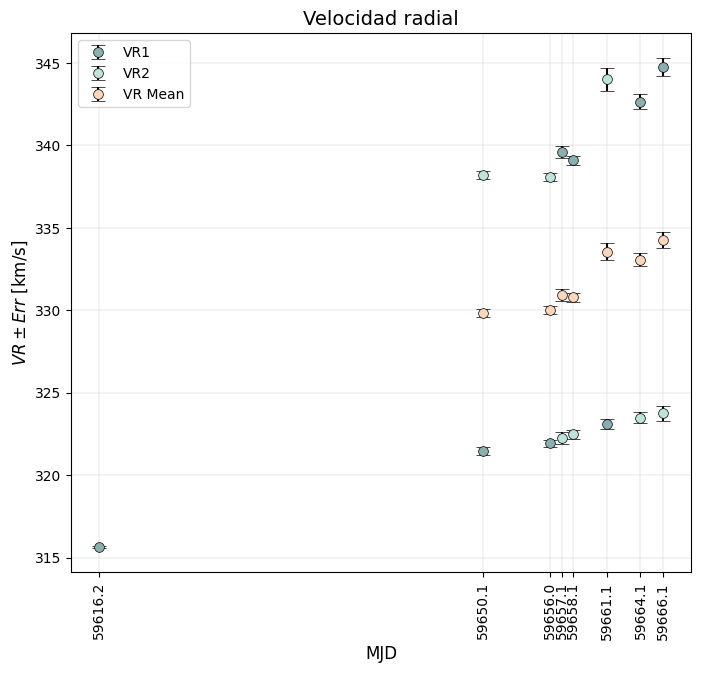

In [35]:
plt.figure(figsize=(8,7))
x = [-22,12,18,19,20,23,26,28]
plt.errorbar(x, VR1,  yerr = Err_VR1, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#89B0AE',mec='k', ms=7, mew=0.5, label ='VR1')
plt.errorbar(x, VR2,  yerr = Err_VR2, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#BEE3DB',mec='k', ms=7, mew=0.5, label ='VR2')
plt.errorbar(x, VR_mean,  yerr = Err_VR_mean, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#FFD6BA',mec='k', ms=7, mew=0.5, label ='VR Mean')
#plt.errorbar(x, VR3,  yerr = Err_VR1, linestyle="None",  fmt="o",  capsize=3,  ecolor="#E36414", mfc='w',mec='#E36414', ms=6, mew=1)

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial',fontsize = 14)
#plt.ylim(398.5,399.8)
plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 


<span style="color:red">**Los resultados anteriores fueron descartados debido a que se encontró que la longitud de onda inicial y el paso era diferente para cada espectro**</span>

## Resultados con diferentes inicio y paso para cada espectro, específico para cada espectro.

In [36]:
TablaVR_Dan = pd.DataFrame()
VR_Dan = [315.66,315.47,315.47,315.44,315.50,315.49,315.46,315.51]
Err_VR_Dan = [0.05,0.06, 0.06, 0.09, 0.06, 0.07, 0.07, 0.09]

Fecha = ["2022-02-06","2022-03-12","2022-03-18","2022-03-19","2022-03-20","2022-03-23","2022-03-26","2022-03-28"]
Fecha_Juliana = [59616.23, 59650.1,  59656.05, 59657.12, 59658.06, 59661.1,  59664.12, 59666.12]
TablaVR_Dan['Fecha (MJD)'] =  np.around(Fecha_Juliana,2)
TablaVR_Dan['VR (km/s)'] = VR_Dan
TablaVR_Dan['Err_VR (km/s)'] = Err_VR_Dan

# Especificar los colores para cada columna
colores_resaltar = {'VR (km/s)': '#89B0AE',  'Err_VR (km/s)': '#BEE3DB'}

# Aplicar estilos al DataFrame
estilos = TablaVR_Dan.style.apply(lambda x: resaltar_columnas(x, colores_resaltar), axis=1)

# Mostrar el DataFrame con los estilos aplicados
estilos

,Fecha (MJD),VR (km/s),Err_VR (km/s)
0,59616.230000,315.660000,0.050000
1,59650.100000,315.470000,0.060000
2,59656.050000,315.470000,0.060000
3,59657.120000,315.440000,0.090000
4,59658.060000,315.500000,0.060000
5,59661.100000,315.490000,0.070000
6,59664.120000,315.460000,0.070000
7,59666.120000,315.510000,0.090000


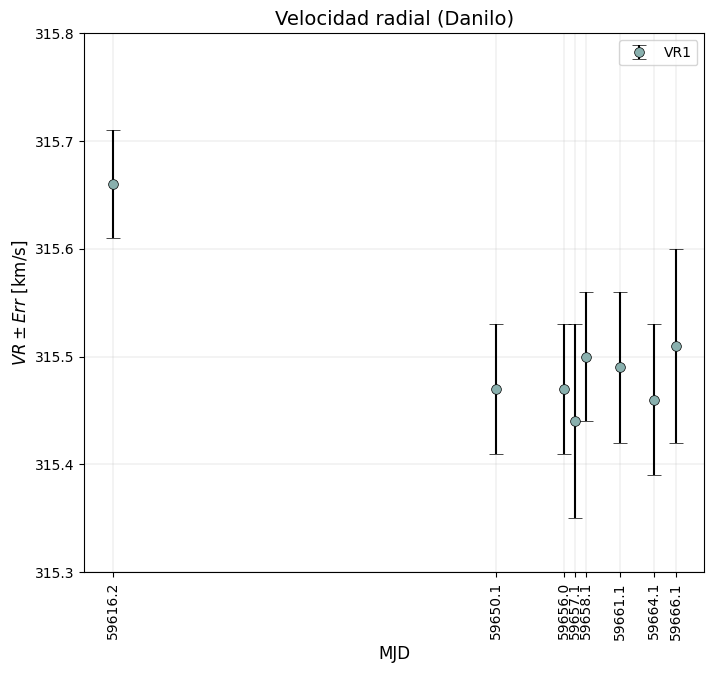

In [37]:
plt.figure(figsize=(8,7))
x = [-22,12,18,19,20,23,26,28]
plt.errorbar(x, VR_Dan,  yerr = Err_VR_Dan, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#89B0AE',mec='k', ms=7, mew=0.5, label ='VR1')

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial (Danilo)',fontsize = 14)
plt.ylim(315.3,315.8)
plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 

Para pasar del vacío al aire: https://www.sdss3.org/dr8/spectro/spectra.php

In [38]:
fits=sys.argv[1]
 
images2=pyfits.open('Espectro_1'+'.fits')

VCA = np.array([])

for k in tqdm(range(len(images2[1].data))):
               VCA = np.append(VCA, images2[1].data[k][0])
            
               
wlvac = np.array([])
wlair = np.array([])

for i in tqdm(np.arange(len(images2[1].data[:]))):

	vac    = 10.**(4.179 + 6.E-6*i)
	wlvac  = np.append(wlvac, vac)
	
	#air    = vac/(1 + (6.4328E-5 + 2.94981E-2/(146.0-(1.0E4/vac)**2)+2.5540E-4/(41.0-(1.0E4/vac)**2)))
	air = VCA[i] / (1.0 + 2.735182E-4 + 131.4182 / VCA[i]**2 + 2.76249E8 / VCA[i]**4)   #Esto lo estoy agregando de aquí: https://www.sdss3.org/dr8/spectro/spectra.php
	wlair  = np.append(wlair, air)


#vac_ = open(sys.argv[1]+'vac.dat', 'a')
air_ = open(str(fits)+'.fitsair.dat', 'a')

for j in tqdm(np.arange(len(wlvac))):

#	vac_.write(str(wlvac[j])+'\t'+str(images2[1].data[j])+'\t'+str(float(1.0))+'\n') # Vacuum 
	air_.write(str(wlair[j])+'\t'+str(images2[1].data[j][1])+'\t'+str(images2[1].data[j][2])+'\n') # Air 

#vac_.close()
air_.close()

100%|███████████████████████████████████| 53237/53237 [00:05<00:00, 9427.83it/s]


In [39]:
print(VCA), print(wlair)

[4333.11786746 4333.16132226 4333.20477231 ... 7106.76319948 7106.81793458
 7106.87265876]
[4331.89929939 4331.94274272 4331.9861813  ... 7104.80065088 7104.85537118
 7104.91008055]


(None, None)

In [40]:
# Define wavelength array
wvl = VCA
print("Input wavelengths: ", wvl)

# Convert wavelength in air to wavelength
# in vacuum. By default, the conversion
# specified by Ciddor 1996 are used.
#wvlVac = pyasl.airtovac2(wvl)
#print("Wavelength in vacuum: ", wvlVac)

# Convert wavelength from vacuum to air
wvlAir = pyasl.vactoair2(wvl)
print("Wavelength in air: ", wvlAir)

Input wavelengths:  [4333.11786746 4333.16132226 4333.20477231 ... 7106.76319948 7106.81793458
 7106.87265876]
Wavelength in air:  [4331.89979767 4331.94324104 4331.98667966 ... 7104.80434907 7104.85906943
 7104.91377886]


In [41]:
# from astropy.io import fits as pyfits
# import numpy as np
# import scipy as sc
# import sys

# #from __future__ import print_function, division
# from PyAstronomy import pyasl
# import numpy as np




# fits=sys.argv[1]
 
# images2=pyfits.open('Espectro_1'+'.fits')

# VCA = np.array([])
# flujo = np.array([])
# for k in range(len(images2[1].data)):
#     VCA = np.append(VCA, images2[1].data[k][0])
#     flujo = np.append(flujo, images2[1].data[k][1])
               
# wlvac = np.array([])
# wlair = np.array([])

# for i in np.arange(124832): #Aquí va la extensión de los datos.

# 	vac    = 10.**(4.179 + 6.E-6*i)
# 	wlvac  = np.append(wlvac, vac)
	
# 	#air    = vac/(1 + (6.4328E-5 + 2.94981E-2/(146.0-(1.0E4/vac)**2)+2.5540E-4/(41.0-(1.0E4/vac)**2)))
# 	# Aquí estoy utilizando la ecuación de Morton (1991, ApJS, 77, 119)
# 	#air = VCA[i] / (1.0 + 2.735182E-4 + 131.4182 / VCA[i]**2 + 2.76249E8 / VCA[i]**4)   #Esto lo estoy agregando de aquí: https://www.sdss3.org/dr8/spectro/spectra.php
# 	# Aquí estoy utilizando la libreria de python
# 	air = pyasl.vactoair2(VCA[i])
# 	wlair  = np.append(wlair, air)


# #vac_ = open(sys.argv[1]+'vac.dat', 'a')
# Err = np.var(flujo)
# air_ = open(str(fits)+'.fitsair.txt', 'a')

# for j in np.arange(len(wlvac)):
    
# #	vac_.write(str(wlvac[j])+'\t'+str(images2[1].data[j])+'\t'+str(float(1.0))+'\n') # Vacuum 
# 	air_.write(str(wlair[j])+'\t'+str(images2[1].data[j][1])+'\t'+str(float(Err))+'\n') # Air 
plt.legend()
# #vac_.close()
# air_.close()

In [42]:
len(images2[1].data)

53237

In [43]:
TablaVR_Air = pd.DataFrame()
VR_Air = [315.48,315.38, 315.40, 315.37, 315.44, 315.40, 315.40, 315.37]
Err_VR_Air = [0.05,0.06, 0.06, 0.08, 0.06, 0.07, 0.07, 0.09]

Fecha = ["2022-02-06","2022-03-12","2022-03-18","2022-03-19","2022-03-20","2022-03-23","2022-03-26","2022-03-28"]
Fecha_Juliana = [59616.23, 59650.1,  59656.05, 59657.12, 59658.06, 59661.1,  59664.12, 59666.12]
TablaVR_Air['Fecha (MJD)'] =  np.around(Fecha_Juliana,2)
TablaVR_Air['VR (km/s)'] = VR_Air
TablaVR_Air['Err_VR (km/s)'] = Err_VR_Air

# Especificar los colores para cada columna
colores_resaltar = {'VR (km/s)': '#89B0AE',  'Err_VR (km/s)': '#BEE3DB'}

# Aplicar estilos al DataFrame
estilos = TablaVR_Air.style.apply(lambda x: resaltar_columnas(x, colores_resaltar), axis=1)

# Mostrar el DataFrame con los estilos aplicados
estilos

,Fecha (MJD),VR (km/s),Err_VR (km/s)
0,59616.230000,315.480000,0.050000
1,59650.100000,315.380000,0.060000
2,59656.050000,315.400000,0.060000
3,59657.120000,315.370000,0.080000
4,59658.060000,315.440000,0.060000
5,59661.100000,315.400000,0.070000
6,59664.120000,315.400000,0.070000
7,59666.120000,315.370000,0.090000


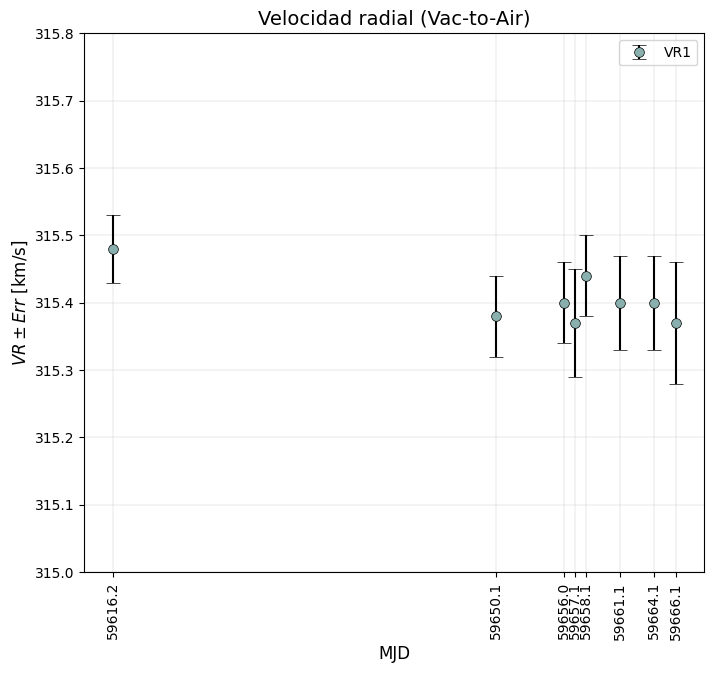

In [44]:
plt.figure(figsize=(8,7))
x = [-22,12,18,19,20,23,26,28]
plt.errorbar(x, VR_Air,  yerr = Err_VR_Air, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#89B0AE',mec='k', ms=7, mew=0.5, label ='VR1')

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial (Vac-to-Air)',fontsize = 14)
plt.ylim(315,315.8)
plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 

In [45]:
TablaVR_AlxUlt = pd.DataFrame()
VR_AlxUlt = [315.62,315.45, 315.37, 315.37, 315.50, 315.39, 315.51, 315.45]
Err_VR_AlxUlt = [0.02, 0.03, 0.03, 0.05, 0.03, 0.04, 0.03, 0.04]

Fecha = ["2022-02-06","2022-03-12","2022-03-18","2022-03-19","2022-03-20","2022-03-23","2022-03-26","2022-03-28"]
Fecha_Juliana = [59616.23, 59650.1,  59656.05, 59657.12, 59658.06, 59661.1,  59664.12, 59666.12]
TablaVR_AlxUlt['Fecha (MJD)'] =  np.around(Fecha_Juliana,2)
TablaVR_AlxUlt['VR (km/s)'] = VR_AlxUlt
TablaVR_AlxUlt['Err_VR (km/s)'] = Err_VR_AlxUlt
TablaVR_AlxUlt = TablaVR_AlxUlt.round(2)  # 2 decimales

# Especificar los colores para cada columna
colores_resaltar = {'VR (km/s)': '#ffb563',  'Err_VR (km/s)': '#ffd29d'}

# Aplicar estilos al DataFrame
estilos = TablaVR_AlxUlt.style.apply(lambda x: resaltar_columnas(x, colores_resaltar), axis=1)

# Mostrar el DataFrame con los estilos aplicados
estilos

,Fecha (MJD),VR (km/s),Err_VR (km/s)
0,59616.230000,315.620000,0.020000
1,59650.100000,315.450000,0.030000
2,59656.050000,315.370000,0.030000
3,59657.120000,315.370000,0.050000
4,59658.060000,315.500000,0.030000
5,59661.100000,315.390000,0.040000
6,59664.120000,315.510000,0.030000
7,59666.120000,315.450000,0.040000


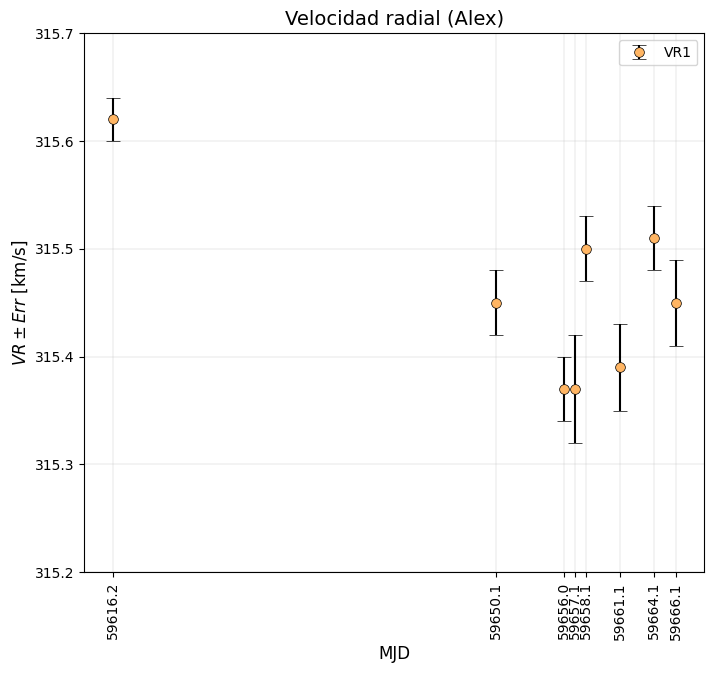

In [46]:
plt.figure(figsize=(8,7))
x = [-22,12,18,19,20,23,26,28]
plt.errorbar(x, VR_AlxUlt,  yerr = Err_VR_AlxUlt, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#ffb563',mec='k', ms=7, mew=0.5, label ='VR1')

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial (Alex)',fontsize = 14)
plt.ylim(315.2,315.7)
plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 

### Vamos a comparar

In [47]:
# Datos Reales 
VR_Real = [315.6384, 315.5357, 315.5778, 315.5968, 315.5781, 315.5318, 315.5052, 315.5417]
print("Los valores reales del Header: ",VR_Real)
# Datos Danilo
print("Los valores de Danilo calculando las λ: ",VR_Dan)
print("Los valores de Danilo con archivos .dat: ",VR_DanUlt)
# Datos Alex
print("Los valores de Alex VactoAir con ecuación: ",VR_Air)
print("Los valores de Alex VactoAir con libreria: ",VR_AlxUlt)

# Ultima actuailización con paso de 0.1 en iSpec
VR_AlxFin = [315.7,315.45,315.33,315.36,315.48,315.39,315.52,315.45]
print("Los valores de Alex VactoAir con libreria minimo paso: ",VR_AlxFin)

Los valores reales del Header:  [315.6384, 315.5357, 315.5778, 315.5968, 315.5781, 315.5318, 315.5052, 315.5417]
Los valores de Danilo calculando las λ:  [315.66, 315.47, 315.47, 315.44, 315.5, 315.49, 315.46, 315.51]
Los valores de Danilo con archivos .dat:  [315.79, 315.55, 315.46, 315.43, 315.58, 315.52, 315.57, 315.54]
Los valores de Alex VactoAir con ecuación:  [315.48, 315.38, 315.4, 315.37, 315.44, 315.4, 315.4, 315.37]
Los valores de Alex VactoAir con libreria:  [315.62, 315.45, 315.37, 315.37, 315.5, 315.39, 315.51, 315.45]
Los valores de Alex VactoAir con libreria minimo paso:  [315.7, 315.45, 315.33, 315.36, 315.48, 315.39, 315.52, 315.45]


In [48]:
Err_Dan_Cal = np.abs(np.array(VR_Dan)-np.array(VR_Real))/np.array(VR_Real)*100
Err_Dan_dat = np.abs(np.array(VR_DanUlt)-np.array(VR_Real))/np.array(VR_Real)*100
Err_Alx_Ecu = np.abs(np.array(VR_Air)-np.array(VR_Real))/np.array(VR_Real)*100
Err_Alx_Lib = np.abs(np.array(VR_AlxUlt)-np.array(VR_Real))/np.array(VR_Real)*100
Err_Alx_Lib_fin = np.abs(np.array(VR_AlxFin)-np.array(VR_Real))/np.array(VR_Real)*100

print("El error de los valores de Danilo calculando las λ es: ",Err_Dan_Cal)
print("El error de los valores de Danilo con archivo .dat es: ",Err_Dan_dat)
print("El error de los valores de Alex con ecuación es: ",Err_Alx_Ecu)
print("El error de los valores de Alex con Libreria es: ",Err_Alx_Lib)
print("El error de los valores de Alex con Libreria es: ",Err_Alx_Lib_fin)

El error de los valores de Danilo calculando las λ es:  [0.00684327 0.02082173 0.03415956 0.04968365 0.02474823 0.01324748
 0.01432623 0.01004622]
El error de los valores de Danilo con archivo .dat es:  [0.04802964 0.00453198 0.03732835 0.05285225 0.00060207 0.00373972
 0.02053849 0.00053876]
El error de los valores de Alex con ecuación es:  [0.05018401 0.04934465 0.0563411  0.07186385 0.04376096 0.04177075
 0.03334335 0.05441436]
El error de los valores de Alex con Libreria es:  [0.00582946 0.02716016 0.06584747 0.07186385 0.02474823 0.04494
 0.00152137 0.02906114]
El error de los valores de Alex con Libreria es:  [0.019516   0.02716016 0.07852263 0.07503245 0.03108581 0.04494
 0.00469089 0.02906114]


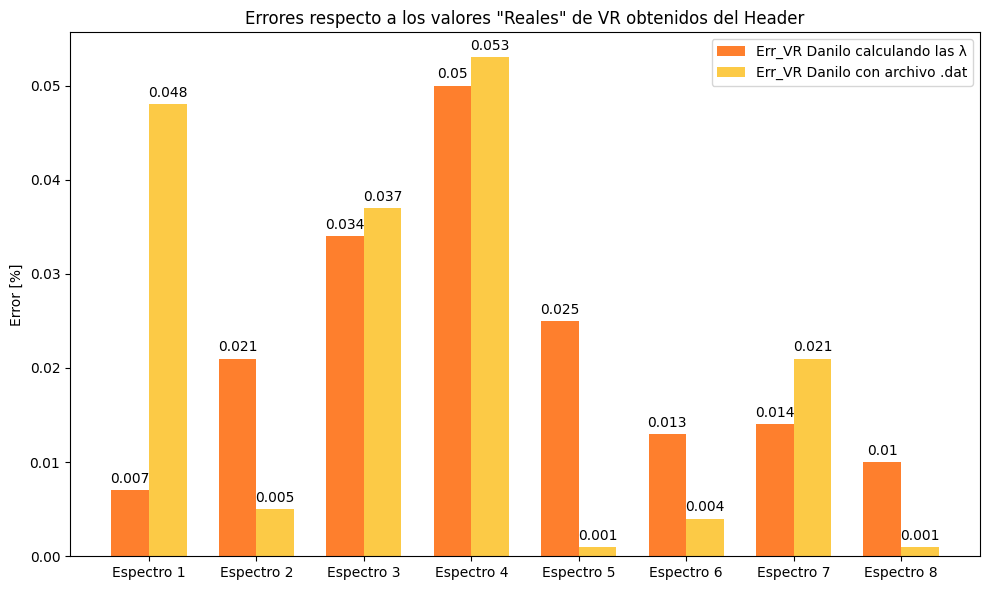

In [49]:
asistencia = ['Espectro 1', 'Espectro 2', 'Espectro 3', 'Espectro 4', 'Espectro 5', 'Espectro 6','Espectro 7','Espectro 8']

#Obtenemos la posicion de cada etiqueta en el eje de X
x = np.arange(len(asistencia))
#tamaño de cada barra
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

#Generamos las barras para el conjunto de hombres
rects1 = ax.bar(x - width/2, np.around(Err_Dan_Cal,3), width, label='Err_VR Danilo calculando las λ', color = '#fe7f2d')
#Generamos las barras para el conjunto de mujeres
rects2 = ax.bar(x + width/2, np.around(Err_Dan_dat,3), width, label='Err_VR Danilo con archivo .dat', color = '#fcca46')

#Añadimos las etiquetas de identificacion de valores en el grafico
ax.set_ylabel('Error [%]')
ax.set_title('Errores respecto a los valores "Reales" de VR obtenidos del Header')
ax.set_xticks(x)
ax.set_xticklabels(asistencia)
#Añadimos un legen() esto permite mmostrar con colores a que pertence cada valor.
ax.legend()

def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#Añadimos las etiquetas para cada barra
autolabel(rects1)
autolabel(rects2)
fig.tight_layout()
#Mostramos la grafica con el metodo show()
plt.show()

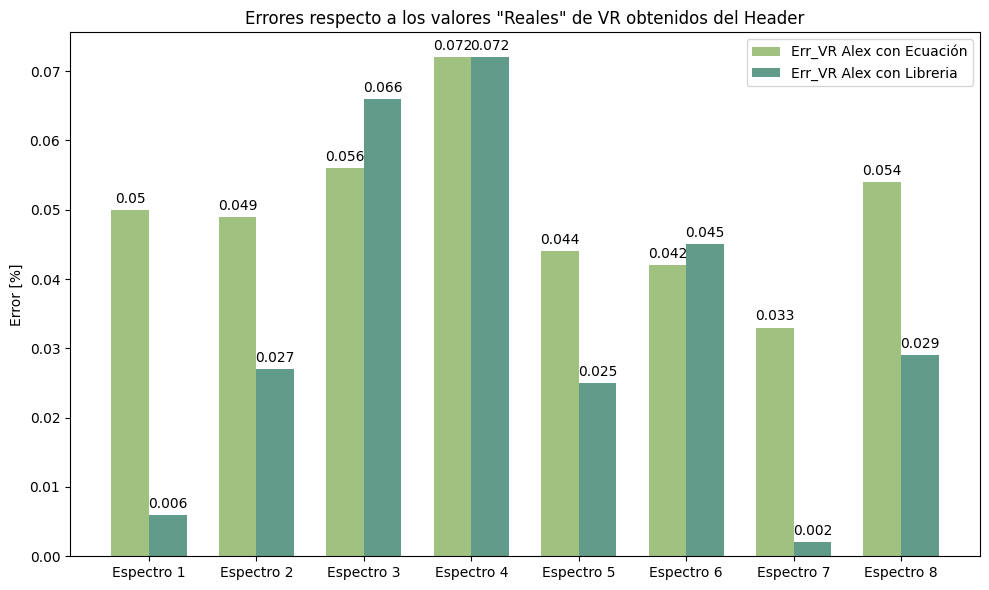

In [50]:
asistencia = ['Espectro 1', 'Espectro 2', 'Espectro 3', 'Espectro 4', 'Espectro 5', 'Espectro 6','Espectro 7','Espectro 8']

#Obtenemos la posicion de cada etiqueta en el eje de X
x = np.arange(len(asistencia))
#tamaño de cada barra
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

#Generamos las barras para el conjunto de hombres
rects1 = ax.bar(x - width/2, np.around(Err_Alx_Ecu,3), width, label='Err_VR Alex con Ecuación', color = '#a1c181')
#Generamos las barras para el conjunto de mujeres
rects2 = ax.bar(x + width/2, np.around(Err_Alx_Lib,3), width, label='Err_VR Alex con Libreria', color = '#619b8a')
#rects3 = ax.bar(x + width/2, np.around(Err_Alx_Lib_fin,3), width, label='Err_VR Alex con Libreria 2', color = '#166D50')

#Añadimos las etiquetas de identificacion de valores en el grafico
ax.set_ylabel('Error [%]')
ax.set_title('Errores respecto a los valores "Reales" de VR obtenidos del Header')
ax.set_xticks(x)
ax.set_xticklabels(asistencia)
#Añadimos un legen() esto permite mmostrar con colores a que pertence cada valor.
ax.legend()

def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#Añadimos las etiquetas para cada barra
autolabel(rects1)
autolabel(rects2)
#autolabel(rects3)

fig.tight_layout()
#Mostramos la grafica con el metodo show()
plt.show()

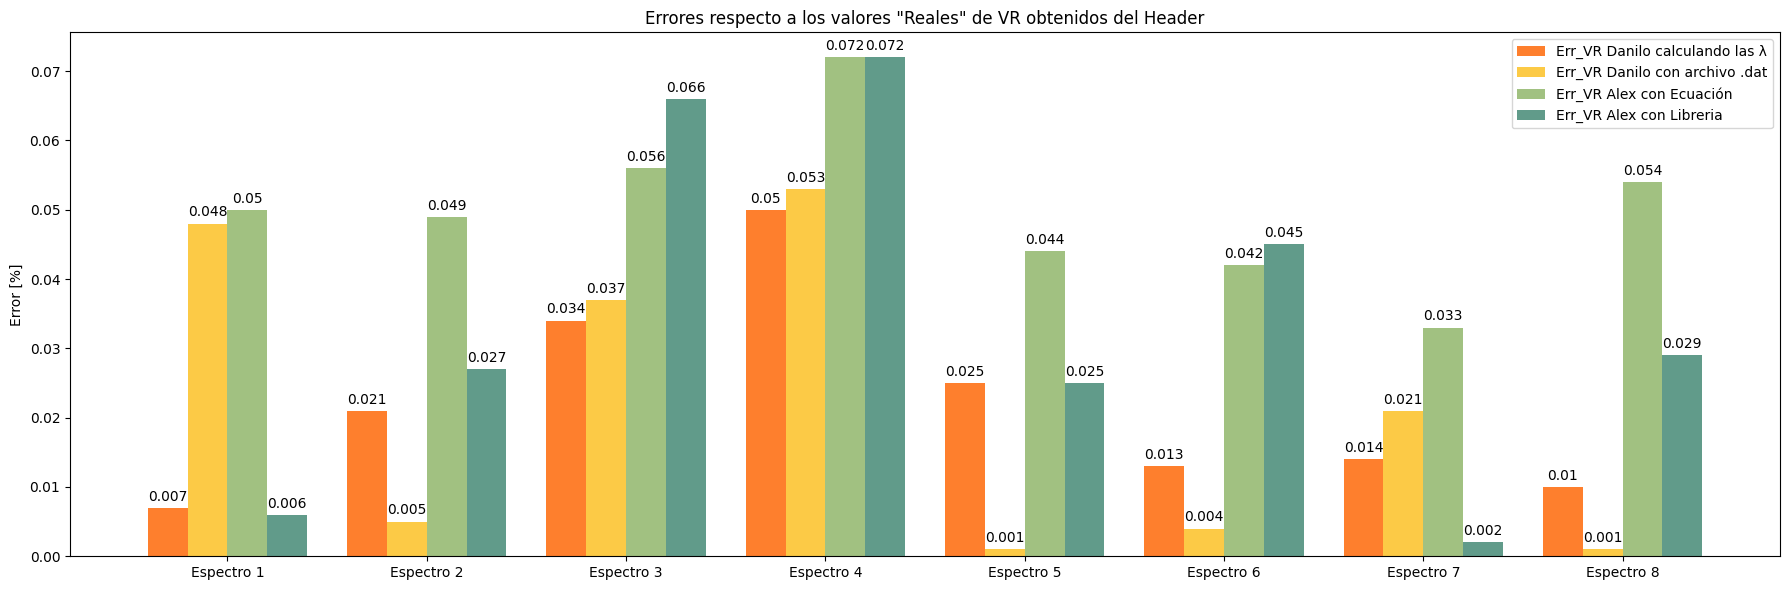

In [51]:
asistencia = ['Espectro 1', 'Espectro 2', 'Espectro 3', 'Espectro 4', 'Espectro 5', 'Espectro 6','Espectro 7','Espectro 8']

#Obtenemos la posicion de cada etiqueta en el eje de X
x = np.arange(len(asistencia))
#tamaño de cada barra
width = 0.2

fig, ax = plt.subplots(figsize=(18,6))

rects1 = ax.bar(x - (width+width/2), np.around(Err_Dan_Cal,3), width, label='Err_VR Danilo calculando las λ', color = '#fe7f2d')
rects2 = ax.bar(x - width/2, np.around(Err_Dan_dat,3), width, label='Err_VR Danilo con archivo .dat', color = '#fcca46')
rects3 = ax.bar(x + width/2, np.around(Err_Alx_Ecu,3), width, label='Err_VR Alex con Ecuación', color = '#a1c181')
rects4 = ax.bar(x + (width+width/2), np.around(Err_Alx_Lib,3), width, label='Err_VR Alex con Libreria', color = '#619b8a')

#Añadimos las etiquetas de identificacion de valores en el grafico
ax.set_ylabel('Error [%]')
ax.set_title('Errores respecto a los valores "Reales" de VR obtenidos del Header')
ax.set_xticks(x)
ax.set_xticklabels(asistencia)
#Añadimos un legen() esto permite mmostrar con colores a que pertence cada valor.
ax.legend()

def autolabel(rects):
    """Funcion para agregar una etiqueta con el valor en cada barra"""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#Añadimos las etiquetas para cada barra
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
#Mostramos la grafica con el metodo show()
plt.show()

In [52]:
print("La media del error de los valores de Danilo calculando las λ es: ",np.around(np.mean(Err_Dan_Cal),3),"%")
print("La media del error de los valores de Danilo con archivo .dat es: ",np.around(np.mean(Err_Dan_dat),3),"%")
print("La media del error de los valores de Alex con ecuación es: ",np.around(np.mean(Err_Alx_Ecu),3),"%")
print("La media del error de los valores de Alex con Libreria es: ",np.around(np.mean(Err_Alx_Lib),3),"%")

La media del error de los valores de Danilo calculando las λ es:  0.022 %
La media del error de los valores de Danilo con archivo .dat es:  0.021 %
La media del error de los valores de Alex con ecuación es:  0.05 %
La media del error de los valores de Alex con Libreria es:  0.034 %


## Analizando los resultados obtenidos en otros trabajos

In [53]:
c1 = 'background-color: #f07167'
c2 = 'background-color: #a8dadc'
d = {24:c1,25:c2,26:c2,27:c2,28:c2,29:c2,30:c2,31:c2,32:c2}


In [54]:
HJD = [45340.69,45684.797,45864.434,46097.658,46397.826,46746.858,46775.595,46811.682,47208.394,47458.704,47511.857,47567.393,47855.642,47958.339,47987.497, 48202.697,  48229.645, 48334.380, 49058.361, 49060.338,  49371.471, 50082.752, 50411.600, 50461.480, 54194.052, 59616.23, 59650.1,  59656.05, 59657.12, 59658.06, 59661.1,  59664.12, 59666.12]  
RV = [315.30,314.79,315.71,314.78,314.95,314.56,316.07,314.98,316.01,315.83,315.11,315.39,315.44,317.36,314.78,315.63,316.10,314.95,315.00,314.32,315.37,313.99,316.66,317.72, 315.63, 315.62,315.45, 315.37, 315.37, 315.50, 315.39, 315.51, 315.45] #km/s
ϵ_RV = [0.33,0.33,0.46,0.34,0.30,0.31,0.56,0.31,0.49,0.70,0.33,0.56,0.57,0.66,0.31,0.45,0.56,0.62,0.67,0.80,0.58,0.34,0.56,0.63, 0.23,0.02, 0.03, 0.03, 0.05, 0.03, 0.04, 0.03, 0.04]
Instrumento = ['SO','SO','SO','SO','SO','SO','NO','SO','NO','NO','SO','NO','NO','NO','SO','NO','NO','NO','NO','NO','NO','SO','NO','NO','FEROS','FIDEOS','FIDEOS','FIDEOS','FIDEOS','FIDEOS','FIDEOS','FIDEOS','FIDEOS']

df_VR = pd.DataFrame()
df_VR['HJD'] = HJD
df_VR['RV [km/s]'] = RV
df_VR['$ϵ_{RV}$ [km/s]'] = ϵ_RV
df_VR['Instrumento'] = Instrumento

df_VR.style.apply(lambda x: x.index.map(d))

,HJD,RV [km/s],$ϵ_{RV}$ [km/s],Instrumento
0,45340.690000,315.300000,0.330000,SO
1,45684.797000,314.790000,0.330000,SO
2,45864.434000,315.710000,0.460000,SO
3,46097.658000,314.780000,0.340000,SO
4,46397.826000,314.950000,0.300000,SO
5,46746.858000,314.560000,0.310000,SO
6,46775.595000,316.070000,0.560000,NO
7,46811.682000,314.980000,0.310000,SO
8,47208.394000,316.010000,0.490000,NO
9,47458.704000,315.830000,0.700000,NO


*  Los espectros del artículo se tomaron con CORAVEL (CORrelation-RAdial-VELocities) spectrovelocimeters has been used (NO = CORAVEL north at the Observatoire de Haute Provence; SO = CORAVEL south on the Danish 1.54-m telescope at ESO).

    **Resolución:** 20000
    
    **Telescopio:** Danish 1.54-m telescope
    
    **Ref:** [https://www.eso.org/public/spain/teles-instr/lasilla/danish154/coravel/?lang]
    

* El resultado de Pereira se obtuvo con el espectrografo FEROS (The Fiber-fed Extended Range Optical Spectrograph) 

     **Resolución:** 48000 
     
     **Telescopio:** MPG/ESO 2.2-metre telescope 
     
     **Ref:** [https://www.eso.org/public/teles-instr/lasilla/mpg22/feros/]
     
    
* Los espectros de nosotros fueron tomados con FIDEOS (Fiber Dual Echelle Optical Spectrograph) 

    **Resolución:** 40000 
    
    **Telescopio:** ESO 1-metre telescope 
    
    **Ref:** [https://www.eso.org/public/teles-instr/lasilla/1metre/fideos/]
    


In [55]:
Tabla_artículo = pd.DataFrame()
Tabla_artículo['RV (km/s)'] = [RV[25],RV[26],RV[27],RV[28],RV[29],RV[30],RV[31],RV[32],315.96472,RV[24],316.21,315.28, 322, 315.30, 317, 317]
Tabla_artículo['$ϵ_{RV}$ (km/s)'] = [ϵ_RV[25],ϵ_RV[26],ϵ_RV[27],ϵ_RV[28],ϵ_RV[29],ϵ_RV[30],ϵ_RV[31],ϵ_RV[32], 'NaN',ϵ_RV[24],0.23,0.16, 0.80, 'NaN', 10, 'NaN']
Tabla_artículo['Ref'] = ['Este Trabajo (2024)','Este Trabajo (2024)','Este Trabajo (2024)','Este Trabajo (2024)','Este Trabajo (2024)','Este Trabajo (2024)','Este Trabajo (2024)','Este Trabajo (2024)','GAIA DR3 (2022)','Pereira et al(2019)','GAIA DR2 (2018)','Karinkuzhi & Goswami (2015)', 'Gontcharov (2006)', 'Jorissen et al (2005)', 'Beers & Sommer-Larsen (1995)', 'Luck & Bond (1991)']


c1 = 'background-color: #f28482'
c2 = 'background-color: #a8dadc'
c3 = 'background-color: #eae2b7'
d = {0:c2,1:c2,2:c2,3:c2,4:c2,5:c2,6:c2,7:c2,8:c3,9:c1,10:c1,11:c1,12:c1,13:c1,14:c1,15:c1}


Tabla_artículo.style.apply(lambda x: x.index.map(d))

,RV (km/s),$ϵ_{RV}$ (km/s),Ref
0,315.620000,0.020000,Este Trabajo (2024)
1,315.450000,0.030000,Este Trabajo (2024)
2,315.370000,0.030000,Este Trabajo (2024)
3,315.370000,0.050000,Este Trabajo (2024)
4,315.500000,0.030000,Este Trabajo (2024)
5,315.390000,0.040000,Este Trabajo (2024)
6,315.510000,0.030000,Este Trabajo (2024)
7,315.450000,0.040000,Este Trabajo (2024)
8,315.964720,NaN,GAIA DR3 (2022)
9,315.630000,0.230000,Pereira et al(2019)


| MJD | $V_R$ | Ref |
| --- | --- | --- |
| 43241.71 | 317 | Luck & Bond (1991) |


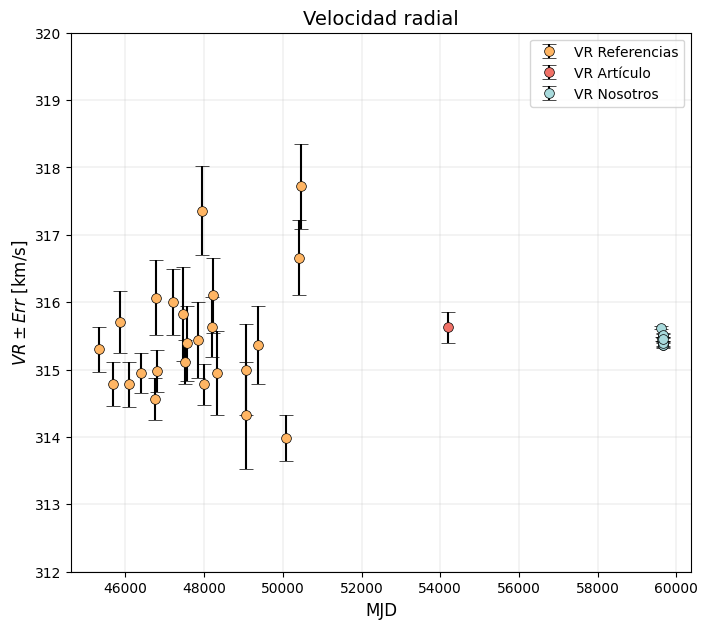

In [56]:
plt.figure(figsize=(8,7))
plt.errorbar(HJD[:24], RV[:24],  yerr = ϵ_RV[:24], linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#ffb563',mec='k', ms=7, mew=0.5, label ='VR Referencias')
plt.errorbar(HJD[24], RV[24],  yerr = ϵ_RV[24], linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#f07167',mec='k', ms=7, mew=0.5, label ='VR Artículo')
plt.errorbar(HJD[25:], RV[25:],  yerr = ϵ_RV[25:], linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#a8dadc',mec='k', ms=7, mew=0.5, label ='VR Nosotros')

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial',fontsize = 14)
plt.ylim(312,320)
#plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 

In [57]:
'''import matplotlib.pyplot as plt
import numpy as np
import plottools
fig,ax = plt.subplots()
x = np.linspace(0,1,100)
y = 1-x + 0.02*(2*np.random.random(len(x))-1)
ax.plot(x,y)
ax_zoom = plottools.zoom_axes(fig,ax,[0.1,0.2],[0.8,0.9],[0.6,0.9],[0.6,0.9])
ax_zoom.plot(x,y)
plt.show()'''

'import matplotlib.pyplot as plt\nimport numpy as np\nimport plottools\nfig,ax = plt.subplots()\nx = np.linspace(0,1,100)\ny = 1-x + 0.02*(2*np.random.random(len(x))-1)\nax.plot(x,y)\nax_zoom = plottools.zoom_axes(fig,ax,[0.1,0.2],[0.8,0.9],[0.6,0.9],[0.6,0.9])\nax_zoom.plot(x,y)\nplt.show()'

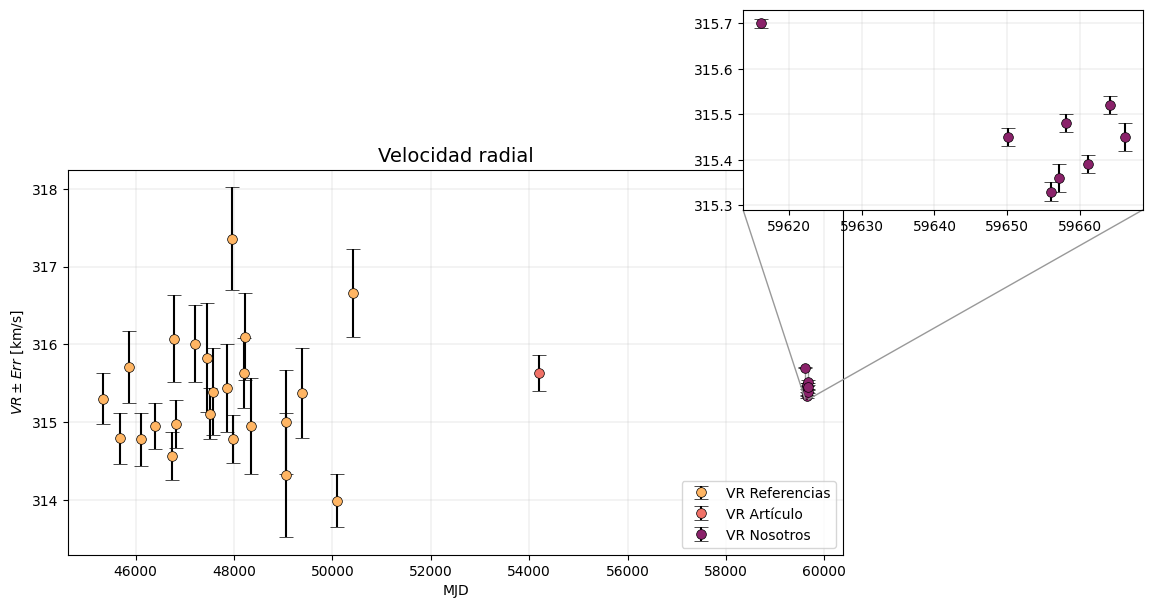

In [60]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
ax.errorbar(HJD[:23], RV[:23],  yerr = ϵ_RV[:23], linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#ffb563',mec='k', ms=7, mew=0.5, label ='VR Referencias')
ax.errorbar(HJD[24], RV[24],  yerr = ϵ_RV[24], linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#f07167',mec='k', ms=7, mew=0.5, label ='VR Artículo')

VR_AlxUlt = [315.70, 315.45, 315.33, 315.36, 315.48, 315.39, 315.52, 315.45] #[316.12,315.44, 315.35, 315.34, 315.54, 315.42,315.51, 315.49] #Estos últimos datos fueron con el espectro más amplio hacía el azul. 
Err_VR_AlxUlt = [0.01,0.02,0.02,0.03,0.02,0.02,0.02,0.03]#[0.01, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.03]

ax.errorbar(HJD[25:], VR_AlxUlt,  yerr = Err_VR_AlxUlt, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#8a226a',mec='k', ms=7, mew=0.5, label ='VR Nosotros')
ax.grid(linestyle='-', linewidth=0.2)
ax.set_xlabel('MJD')
ax.set_ylabel('$VR \pm Err $ [km/s]')
ax.set_title('Velocidad radial',fontsize = 14)
 # location for the zoomed portion 
sub_axes = plt.axes([.8, .8, 0.4,0.4])

# plot the zoomed portion
sub_axes.errorbar(HJD[25:], VR_AlxUlt,  yerr = Err_VR_AlxUlt, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#8a226a',mec='k', ms=7, mew=0.5, label ='VR Nosotros')

mark_inset(ax, sub_axes, loc1=3, loc2=4, fc="none", ec="0.6")

# insert the zoomed figure
# plt.setp(sub_axes)
plt.grid(linestyle='-', linewidth=0.2)
ax.legend(loc = 'lower right')
plt.show()

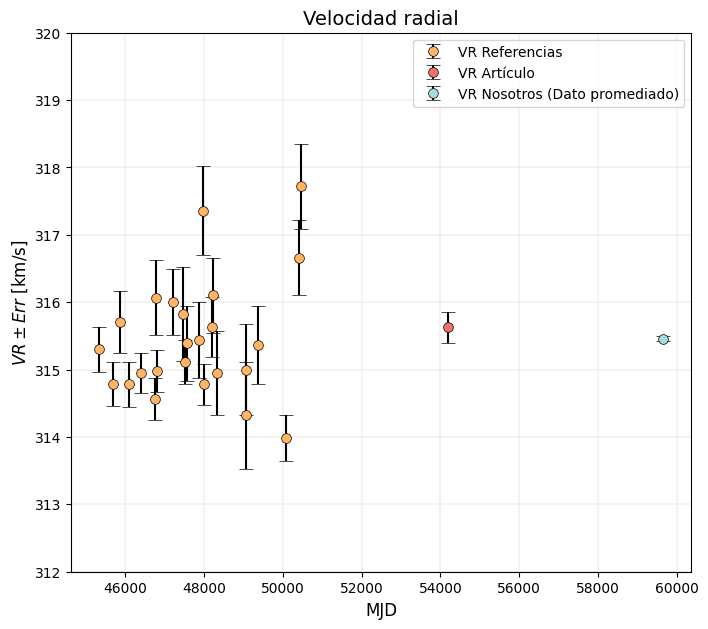

In [61]:
plt.figure(figsize=(8,7))
plt.errorbar(HJD[:24], RV[:24],  yerr = ϵ_RV[:24], linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#ffb563',mec='k', ms=7, mew=0.5, label ='VR Referencias')
plt.errorbar(HJD[24], RV[24],  yerr = ϵ_RV[24], linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#f07167',mec='k', ms=7, mew=0.5, label ='VR Artículo')
plt.errorbar(np.mean(HJD[25:]), np.mean(RV[25:]),  yerr = np.mean(ϵ_RV[25:]), linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#a8dadc',mec='k', ms=7, mew=0.5, label ='VR Nosotros (Dato promediado)')

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial',fontsize = 14)
plt.ylim(312,320)
#plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 

In [62]:
TablaVR_AlxUlt = pd.DataFrame()
VR_AlxUlt = [315.70, 315.45, 315.33, 315.36, 315.48, 315.39, 315.52, 315.45] #[316.12,315.44, 315.35, 315.34, 315.54, 315.42,315.51, 315.49] #Estos últimos datos fueron con el espectro más amplio hacía el azul. 
Err_VR_AlxUlt = [0.01,0.02,0.02,0.03,0.02,0.02,0.02,0.03]#[0.01, 0.02, 0.02, 0.03, 0.02, 0.02, 0.02, 0.03]

Fecha = ["2022-02-06","2022-03-12","2022-03-18","2022-03-19","2022-03-20","2022-03-23","2022-03-26","2022-03-28"]
Fecha_Juliana = [59616.23, 59650.1,  59656.05, 59657.12, 59658.06, 59661.1,  59664.12, 59666.12]
TablaVR_AlxUlt['Fecha (MJD)'] =  np.around(Fecha_Juliana,2)
TablaVR_AlxUlt['VR (km/s)'] = VR_AlxUlt
TablaVR_AlxUlt['Err_VR (km/s)'] = Err_VR_AlxUlt
TablaVR_AlxUlt = TablaVR_AlxUlt.round(2)  # 2 decimales

# Especificar los colores para cada columna
colores_resaltar = {'VR (km/s)': '#97A97C',  'Err_VR (km/s)': '#B5C99A'}

# Aplicar estilos al DataFrame
estilos = TablaVR_AlxUlt.style.apply(lambda x: resaltar_columnas(x, colores_resaltar), axis=1)

# Mostrar el DataFrame con los estilos aplicados
estilos

,Fecha (MJD),VR (km/s),Err_VR (km/s)
0,59616.230000,315.700000,0.010000
1,59650.100000,315.450000,0.020000
2,59656.050000,315.330000,0.020000
3,59657.120000,315.360000,0.030000
4,59658.060000,315.480000,0.020000
5,59661.100000,315.390000,0.020000
6,59664.120000,315.520000,0.020000
7,59666.120000,315.450000,0.030000


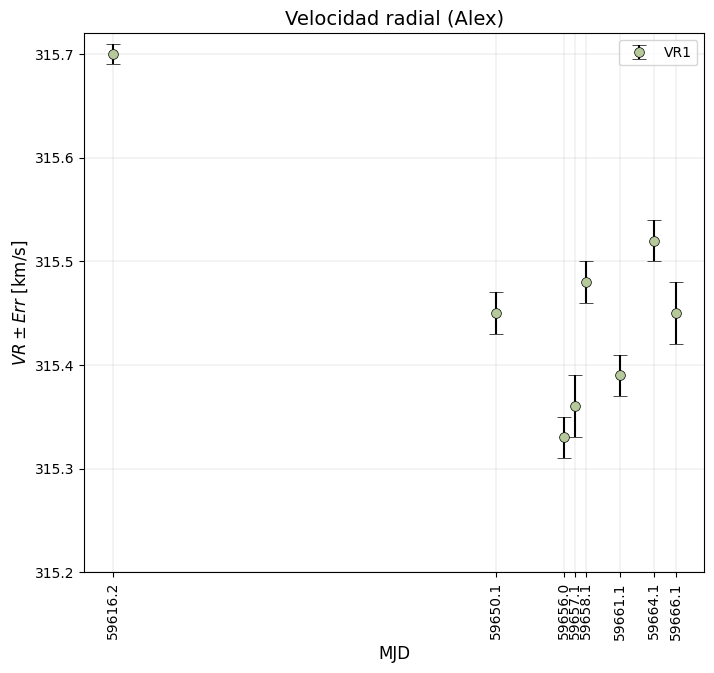

In [63]:
plt.figure(figsize=(8,7))
x = [-22,12,18,19,20,23,26,28]
plt.errorbar(x, VR_AlxUlt,  yerr = Err_VR_AlxUlt, linestyle="None",  fmt="o",  capsize=5,  ecolor="k", mfc='#B5C99A',mec='k', ms=7, mew=0.5, label ='VR1')

plt.xlabel('MJD',fontsize = 12)
plt.ylabel('$VR \pm Err $ [km/s]' ,fontsize = 12)
plt.title('Velocidad radial (Alex)',fontsize = 14)
plt.ylim(315.2,315.72)
plt.xticks(x, np.around(Fecha_Juliana,1), rotation=90)
plt.grid(linestyle='-', linewidth=0.2)
plt.legend()
plt.show() 

## Periodograma
https://docs.astropy.org/en/stable/timeseries/lombscargle.html#peak-significance-and-false-alarm-probabilities

## Datos obtenidos del espectro - Alex
En este caso, los resultados son los obtenidos por medio de iSpec, con el proceso que yo he venido adelantando por mi parte, es decir, poniendo el espectro en 1D y haciendo el cálculo de VR con la cross correlation function.

-----------------------------------------------
Poder máximo con el dato:  14.500323089585894
Frecuencia: 0.18478024705320367 1 / d
Periodo: 5.41183387265453 d
-----------------------------------------------
Poder máximo sin el dato:  10.716878100785054
Frecuencia: 0.18672766999107723 1 / d 
Periodo: 5.355392695939412 d
-----------------------------------------------


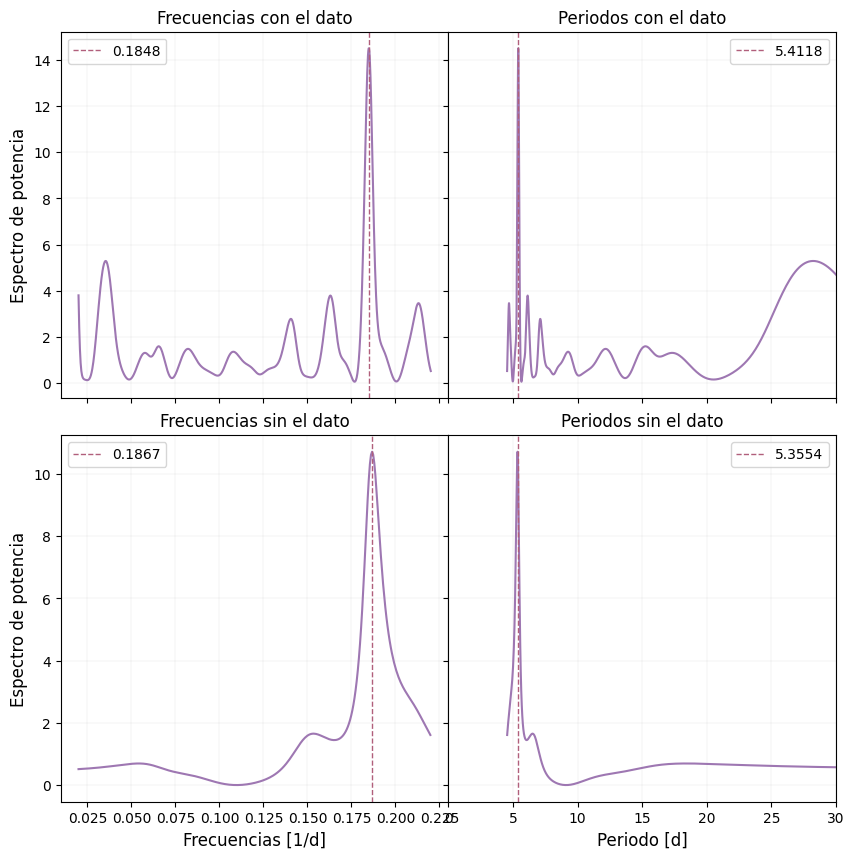

In [2]:
# Supongamos que tienes tus datos de tiempo y velocidades radiales en dos arreglos numpy, por ejemplo:
t = np.array([59616.23271964618, 59650.10320109323, 59656.0512570944, 59657.12144344438, 59658.05911761139, 59661.10135918918, 59664.12034640477, 59666.11733959911])*u.day  # Tiempo de observación
y = np.array([315.70, 315.45, 315.33, 315.36, 315.48, 315.39, 315.52, 315.45])*u.km/u.s  # Velocidades radiales observadas
dy = ([0.01, 0.02,0.02,0.03,0.02,0.02,0.02,0.03])*u.km/u.s

# Calcular el periodograma usando la transformada de Lomb-Scargle
frequency, power = LombScargle(t, y,dy, normalization = 'model').autopower(minimum_frequency=0.02*1/u.day,maximum_frequency=0.22*1/u.day,samples_per_peak=100,method='fastchi2')
frequency_sin, power_sin = LombScargle(t[1:], y[1:],dy[1:], normalization = 'model').autopower(minimum_frequency=0.02*1/u.day,maximum_frequency=0.22*1/u.day,samples_per_peak=100,method='fastchi2')

print("-----------------------------------------------")
print("Poder máximo con el dato: ",max(power))
f = frequency[np.argmax(power)]
p = 1/frequency[np.argmax(power)]
print(f"Frecuencia: {f}")
print(f"Periodo: {p}")
print("-----------------------------------------------")
print("Poder máximo sin el dato: ",max(power_sin))
f_sin = frequency_sin[np.argmax(power_sin)]
p_sin = 1/frequency_sin[np.argmax(power_sin)]
print(f"Frecuencia: {f_sin} ")
print(f"Periodo: {p_sin}")
print("-----------------------------------------------")


# Graficar el periodograma
fig = plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
(ax1,ax2), (ax3,ax4) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Frecuencias con el dato', fontsize = 12)
ax2.set_title('Periodos con el dato', fontsize = 12)
ax3.set_title('Frecuencias sin el dato', fontsize = 12)
ax4.set_title('Periodos sin el dato', fontsize = 12)

ax1.plot(frequency, power, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax2.plot(1/frequency, power, '-',color = '#9E77B2' )  # Periodo sin el dato 
ax3.plot(frequency_sin, power_sin, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax4.plot(1/frequency_sin, power_sin, '-',color = '#9E77B2' )  # Periodo sin el dato 

ax1.axvline(f.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f.value,4))
ax2.axvline(p.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p.value,4))
ax3.axvline(f_sin.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f_sin.value,4))
ax4.axvline(p_sin.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p_sin.value,4))


ax1.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax1.set_ylabel('Espectro de potencia',fontsize = 12)
ax2.set_xlabel('Periodo[d]',fontsize = 12)
ax2.set_ylabel('Espectro de potencia',fontsize = 12)

ax3.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax3.set_ylabel('Espectro de potencia',fontsize = 12)
ax4.set_xlabel('Periodo [d]',fontsize = 12)
ax4.set_ylabel('Espectro de potencia',fontsize = 12)

ax2.set_xlim(0,30)
ax4.set_xlim(0,30)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)


El periodograma muestra un pico con una frecuencia de aproximadamente $0.1871$ ciclo por unidad de tiempo.

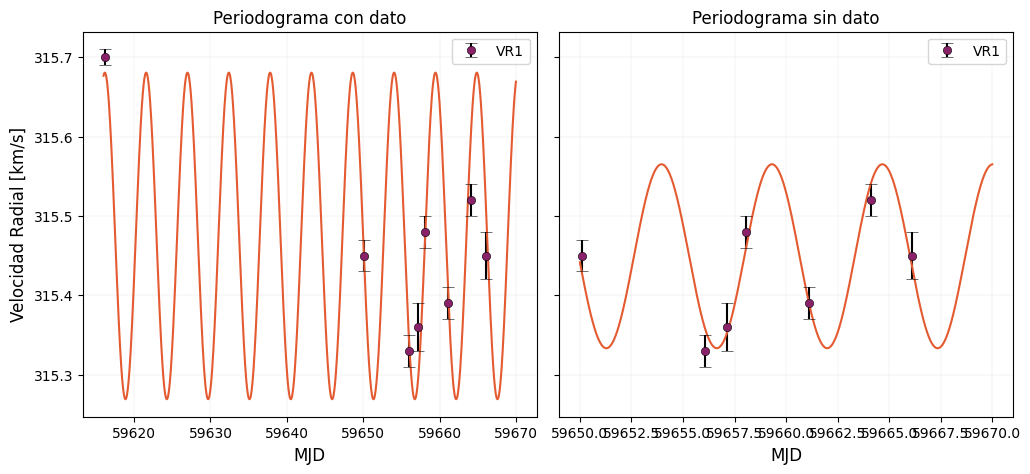

In [3]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(59616,59670,1000)*u.day
ls = LombScargle(t, y, dy,  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit = ls.model(t_fit, best_frequency)

best_frequency_sin = frequency_sin[np.argmax(power_sin)]
t_fit_sin = np.linspace(59650,59670,1000)*u.day
ls_sin = LombScargle(t[1:], y[1:], dy[1:],  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit_sin = ls_sin.model(t_fit_sin, best_frequency_sin)

# Graficar el periodograma
fig = plt.figure(figsize=(12,5))

gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0.05)
(ax1,ax2) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Periodograma con dato', fontsize = 12)
ax2.set_title('Periodograma sin dato', fontsize = 12)

ax1.plot(np.array(t_fit), np.array(y_fit), '-', color = '#e45a31', markersize = 0.5) 
ax1.errorbar(np.array(t), y.value,  yerr = dy.value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')

ax2.plot(np.array(t_fit_sin), np.array(y_fit_sin), '-', color = '#e45a31', markersize = 0.5)  
ax2.errorbar(np.array(t[1:]), y[1:].value,  yerr = dy[1:].value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')


ax1.set_xlabel('MJD',fontsize = 12)
ax1.set_ylabel('Velocidad Radial [km/s]',fontsize = 12)
ax2.set_xlabel('MJD',fontsize = 12)
ax2.set_ylabel('Velocidad Radial [km/s]',fontsize = 12)

# ax1.axhline(315.68, color = "red", linewidth = 1, linestyle = "dashed");
# ax1.axhline(315.27, color = "red", linewidth = 1, linestyle = "dashed");

# ax2.axhline(315.332, color = "red", linewidth = 1, linestyle = "dashed");
# ax2.axhline(315.565, color = "red", linewidth = 1, linestyle = "dashed");

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)

In [4]:
315.68 - 315.27

0.410000000000025

In [5]:
315.565 - 315.332

0.2330000000000041

<span style="color:#8a226a">Aquí estamos viendo el ajuste de la función (modelo), que es una combinación línea de seno y coseno, sin embargo para poderlo tomar como el periodograma, debemos poner estos valores en fase, es decir, poner todos los datos en un periodo</span>

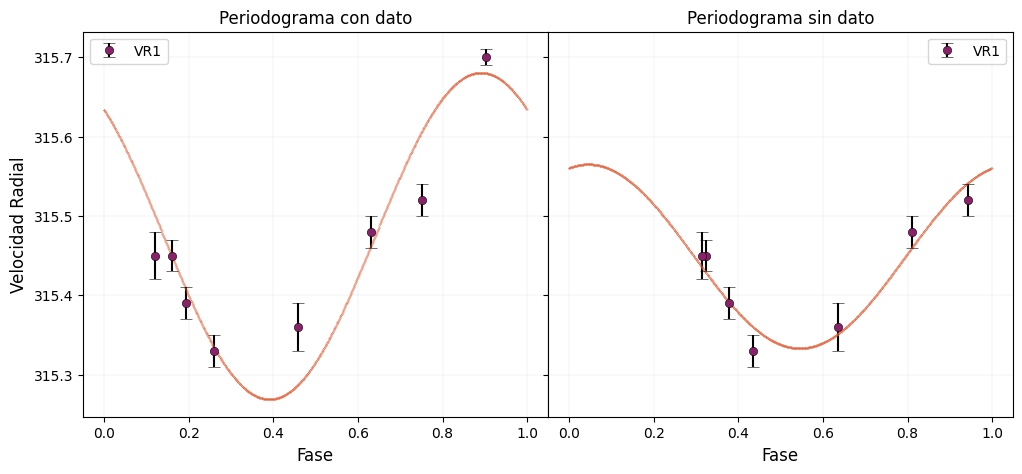

In [6]:
best_frequency = frequency[np.argmax(power)]
pt_fit = np.linspace(0,1/best_frequency.value,1000)*u.day
ls = LombScargle(t, y, dy,  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
py_fit = ls.model(pt_fit, best_frequency)

best_frequency_sin = frequency_sin[np.argmax(power_sin)]
pt_fit_sin = np.linspace(0,1/best_frequency_sin.value,1000)*u.day
ls_sin = LombScargle(t[1:], y[1:], dy[1:],  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
py_fit_sin = ls_sin.model(pt_fit_sin, best_frequency_sin)

phase = (t / p) % 1
phasefit = (pt_fit / p) %1
phase_sin = (t / p_sin) % 1
phasefit_sin = (pt_fit_sin / p_sin) %1

# Graficar el periodograma
fig = plt.figure(figsize=(12,5))

gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0)
(ax1,ax2) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Periodograma con dato', fontsize = 12)
ax2.set_title('Periodograma sin dato', fontsize = 12)

ax1.plot(np.array(phasefit), np.array(py_fit), '.', color = '#e45a31', markersize = 0.5) 
ax1.errorbar(np.array(phase), y.value,  yerr = dy.value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')

ax2.plot(np.array(phasefit_sin), np.array(py_fit_sin), '.', color = '#e45a31', markersize = 0.5)  
ax2.errorbar(np.array(phase_sin[1:]), y[1:].value,  yerr = dy[1:].value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')


ax1.set_xlabel('Fase',fontsize = 12)
ax1.set_ylabel('Velocidad Radial',fontsize = 12)
ax2.set_xlabel('Fase',fontsize = 12)
ax2.set_ylabel('Velocidad Radial',fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)

#### Probabilidad de falsa alarma de máximos del periodograma bajo la hipótesis nula.

Esto proporciona una estimación de la probabilidad de falsa alarma dada la altura del pico más grande en el periodograma, basada en la hipótesis nula de datos no variables con ruido gaussiano.

##### Diferentes métodos de 'False Alarm Approximations'
* **Baluev:** (Valor predeterminado) implementa la aprocimación propuesta por Baluev 2008, que emplea estadísticas de valores extremos para calcular un límite superior de la probabilidad de falsa alrarma para el caso alias-free.

* **Bootstrap:** Implementa simulación de arranque: calcula efectivamente muchos periodogramas de Lomb-Scargle sobre datos simulados en los mismos tiempos de observación. Determina con mucha precisión la probabilidad de falsa alarma.

* **Davies:** Relacionado con el método Baluev, pero pierde precisión con grandes probabilidades de falsas alarmas.

* **Naive:** Es un método básico basado en el supuesto de que las áreas bien separadas del periodograma son independientes, estimación muy pobre de la probabilidad de falsa alarma y no debe utilizarse en la práctica.

**En general, los usuarios deben utilizar el enfoque bootstrap cuando sea computacionalmente factible y el enfoque Baluev en caso contrario.**

In [7]:
print("-"*80)
print("Valor del máximo pico: ", power.max())
print("Diferentes Métodos de 'False Alarm Approximations' con dato")
print("baluev: ",ls.false_alarm_probability(power.max(),method='baluev', maximum_frequency = frequency.max()))
print("\x1b[1;35m"+f"bootstrap: {ls.false_alarm_probability(power.max(),method='bootstrap', maximum_frequency = frequency.max())}"+"\033[0m")
print("davies: ",ls.false_alarm_probability(power.max(),method='davies', maximum_frequency = frequency.max()))
print("naive: ",ls.false_alarm_probability(power.max(), method='naive', maximum_frequency = frequency.max()))
print("-"*80)
print("Valor del máximo pico: ", power_sin.max())
print("Diferentes Métodos de 'False Alarm Approximations' sin dato")
print("baluev: ",ls_sin.false_alarm_probability(power_sin.max(),method='baluev', maximum_frequency = frequency_sin.max()))
print("\x1b[1;35m"+f"bootstrap: {ls_sin.false_alarm_probability(power_sin.max(),method='bootstrap', maximum_frequency = frequency_sin.max())}"+"\033[0m")
print("davies: ",ls_sin.false_alarm_probability(power_sin.max(),method='davies', maximum_frequency = frequency_sin.max()))
print("naive: ",ls_sin.false_alarm_probability(power_sin.max(), method='naive', maximum_frequency = frequency_sin.max()))
print("-"*80)

--------------------------------------------------------------------------------
Valor del máximo pico:  14.500323089585894
Diferentes Métodos de 'False Alarm Approximations' con dato
baluev:  0.08457499550009122
bootstrap: 0.137
davies:  0.08836627654766539
naive:  0.011463127621536567
--------------------------------------------------------------------------------
Valor del máximo pico:  10.716878100785054
Diferentes Métodos de 'False Alarm Approximations' sin dato
baluev:  0.10377125142112036
bootstrap: 0.15600000000000003
davies:  0.10953294021211611
naive:  0.025263081394935234
--------------------------------------------------------------------------------


Distribución esperada del periodograma bajo la hipótesis nula.

Esto calcula la distribución de probabilidad esperada o la distribución de probabilidad acumulada de la potencia del periodograma, bajo la hipótesis nula de una señal no variable con ruido gaussiano. 

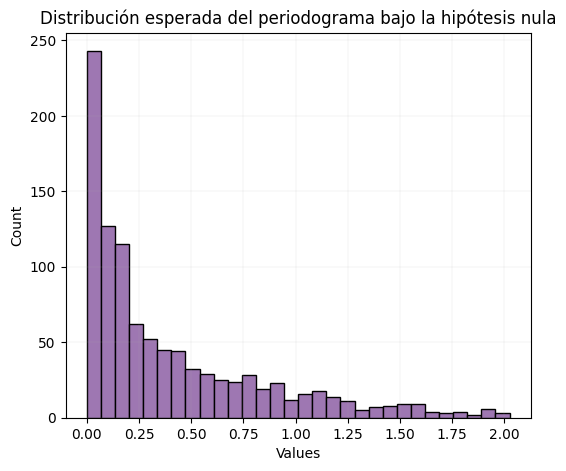

In [8]:
dist = np.array(ls.distribution(power, cumulative = False))
plt.figure(figsize=(6,5))
plt.xlabel('Values')
#plt.ylabel('Velocidad Radial')
plt.title('Distribución esperada del periodograma bajo la hipótesis nula')
sns.histplot(dist, bins = 30,alpha=0.5, facecolor='#9E77B2')
plt.grid(linestyle='-', linewidth=0.1)
plt.show()

In [9]:
probabilities = [0.2, 0.1, 0.05, 0.01]
ls.false_alarm_level(probabilities)

array([12.17297811, 18.28152661, 26.73488834, 61.92966944])

Esto nos dice que para lograr una probabilidad de falsa alarma de:
* 20% se requiere que el pico más alto del periodograma sea aproximadamente 12.17
* 10% se requiere que el pico más alto del periodograma sea aproximadamente 18.28
* 5% se requiere que el pico más alto del periodograma sea aproximadamente 26.73
* 1% se requiere que el pico más alto del periodograma sea aproximadamente 61.93

## Datos obtenidos del espectro - Danilo
En este caso, los resultados son los obtenidos por medio de iSpec, pero en este caso con los datos obtenidos por Danilo.

-----------------------------------------------
Poder máximo con el dato:  5.583066191842951
Frecuencia: 0.18502465546817637 1 / d
Periodo: 5.404685107882807 d
-----------------------------------------------
Poder máximo sin el dato:  7.444960450595623
Frecuencia: 0.35693547526185027 1 / d 
Periodo: 2.8016268185906523 d
-----------------------------------------------


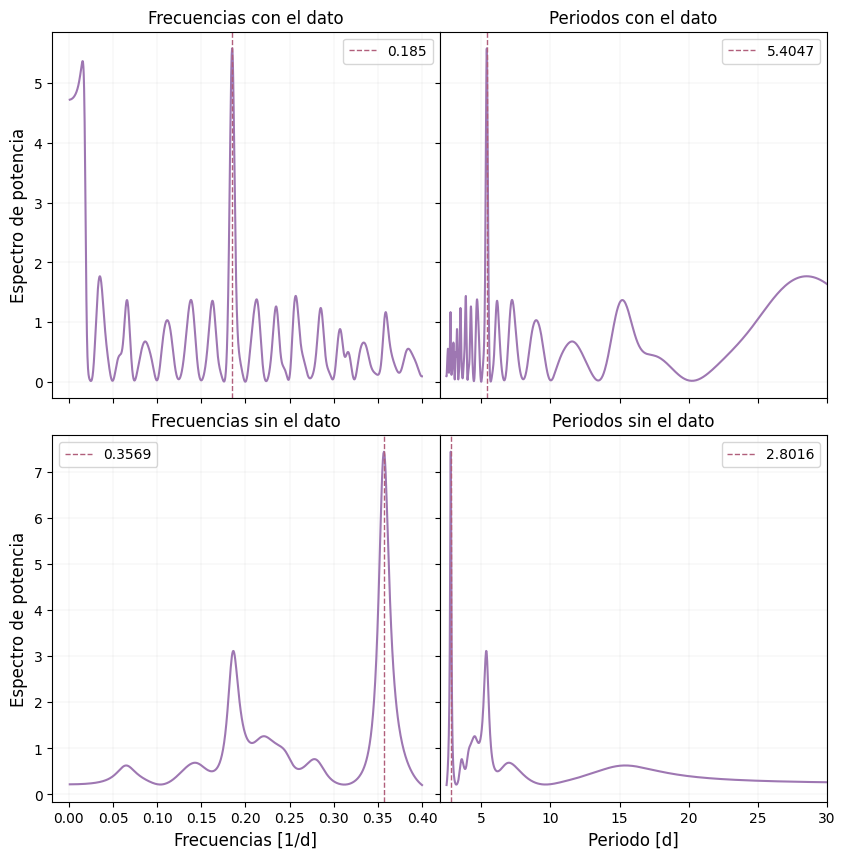

In [14]:
# Supongamos que tienes tus datos de tiempo y velocidades radiales en dos arreglos numpy, por ejemplo:
VR_DanUlt = [315.79,315.55, 315.46, 315.43, 315.58,315.52, 315.57, 315.54]
Err_VR_DanUlt = [0.03,0.03, 0.03, 0.04, 0.03, 0.04, 0.04, 0.04]

t = np.array([59616.23271964618, 59650.10320109323, 59656.0512570944, 59657.12144344438, 59658.05911761139, 59661.10135918918, 59664.12034640477, 59666.11733959911])*u.day  # Tiempo de observación
y = np.array(VR_DanUlt)*u.km/u.s  # Velocidades radiales observadas
dy = (Err_VR_DanUlt)*u.km/u.s

# Calcular el periodograma usando la transformada de Lomb-Scargle
frequency, power = LombScargle(t, y,dy, normalization = 'model').autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
frequency_sin, power_sin = LombScargle(t[1:], y[1:],dy[1:], normalization = 'model').autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')

print("-----------------------------------------------")
print("Poder máximo con el dato: ",max(power))
f = frequency[np.argmax(power)]
p = 1/frequency[np.argmax(power)]
print(f"Frecuencia: {f}")
print(f"Periodo: {p}")
print("-----------------------------------------------")
print("Poder máximo sin el dato: ",max(power_sin))
f_sin = frequency_sin[np.argmax(power_sin)]
p_sin = 1/frequency_sin[np.argmax(power_sin)]
print(f"Frecuencia: {f_sin} ")
print(f"Periodo: {p_sin}")
print("-----------------------------------------------")


# Graficar el periodograma
fig = plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
(ax1,ax2), (ax3,ax4) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Frecuencias con el dato', fontsize = 12)
ax2.set_title('Periodos con el dato', fontsize = 12)
ax3.set_title('Frecuencias sin el dato', fontsize = 12)
ax4.set_title('Periodos sin el dato', fontsize = 12)

ax1.plot(frequency, power, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax2.plot(1/frequency, power, '-',color = '#9E77B2' )  # Periodo sin el dato 
ax3.plot(frequency_sin, power_sin, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax4.plot(1/frequency_sin, power_sin, '-',color = '#9E77B2' )  # Periodo sin el dato 

ax1.axvline(f.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f.value,4))
ax2.axvline(p.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p.value,4))
ax3.axvline(f_sin.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f_sin.value,4))
ax4.axvline(p_sin.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p_sin.value,4))


ax1.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax1.set_ylabel('Espectro de potencia',fontsize = 12)
ax2.set_xlabel('Periodo[d]',fontsize = 12)
ax2.set_ylabel('Espectro de potencia',fontsize = 12)

ax3.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax3.set_ylabel('Espectro de potencia',fontsize = 12)
ax4.set_xlabel('Periodo [d]',fontsize = 12)
ax4.set_ylabel('Espectro de potencia',fontsize = 12)

ax2.set_xlim(2,30)
ax4.set_xlim(2,30)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)


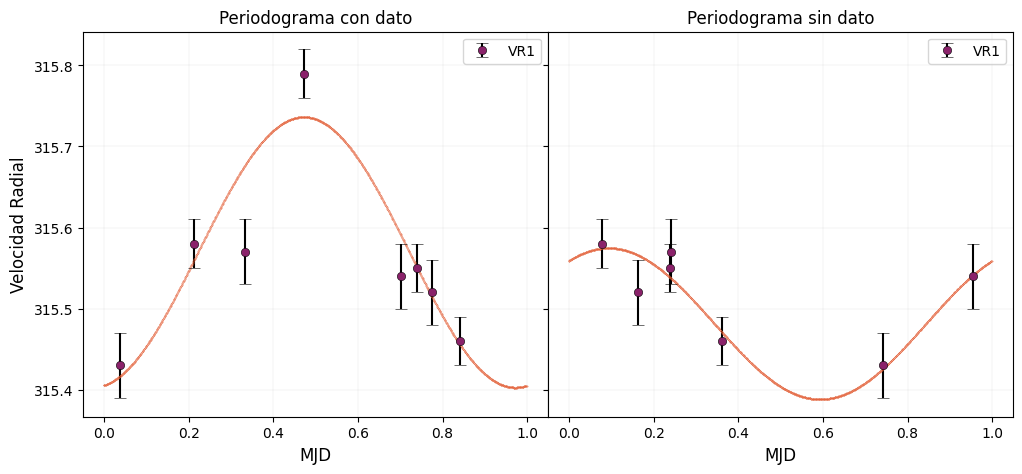

In [69]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(0,1/best_frequency.value,1000)*u.day
ls = LombScargle(t, y, dy,  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit = ls.model(t_fit, best_frequency)

best_frequency_sin = frequency_sin[np.argmax(power_sin)]
t_fit_sin = np.linspace(0,1/best_frequency_sin.value,1000)*u.day
ls_sin = LombScargle(t[1:], y[1:], dy[1:],  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit_sin = ls_sin.model(t_fit_sin, best_frequency_sin)

phase = (t / p) % 1
phasefit = (t_fit / p) %1
phase_sin = (t / p_sin) % 1
phasefit_sin = (t_fit_sin / p_sin) %1

# Graficar el periodograma
fig = plt.figure(figsize=(12,5))

gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0)
(ax1,ax2) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Periodograma con dato', fontsize = 12)
ax2.set_title('Periodograma sin dato', fontsize = 12)

ax1.plot(np.array(phasefit), np.array(y_fit), '.', color = '#e45a31', markersize = 0.5) 
ax1.errorbar(np.array(phase), y.value,  yerr = dy.value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')

ax2.plot(np.array(phasefit_sin), np.array(y_fit_sin), '.', color = '#e45a31', markersize = 0.5)  
ax2.errorbar(np.array(phase_sin[1:]), y[1:].value,  yerr = dy[1:].value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')


ax1.set_xlabel('MJD',fontsize = 12)
ax1.set_ylabel('Velocidad Radial',fontsize = 12)
ax2.set_xlabel('MJD',fontsize = 12)
ax2.set_ylabel('Velocidad Radial',fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)

In [70]:
print("-"*80)
print("Valor del máximo pico: ", power.max())
print("Diferentes Métodos de 'False Alarm Approximations' con dato")
print("baluev: ",ls.false_alarm_probability(power.max(),method='baluev', maximum_frequency = frequency.max()))
print("\x1b[1;35m"+f"bootstrap: {ls.false_alarm_probability(power.max(),method='bootstrap', maximum_frequency = frequency.max())}"+"\033[0m")
print("davies: ",ls.false_alarm_probability(power.max(),method='davies', maximum_frequency = frequency.max()))
print("naive: ",ls.false_alarm_probability(power.max(), method='naive', maximum_frequency = frequency.max()))
print("-"*80)
print("Valor del máximo pico: ", power_sin.max())
print("Diferentes Métodos de 'False Alarm Approximations' sin dato")
print("baluev: ",ls_sin.false_alarm_probability(power_sin.max(),method='baluev', maximum_frequency = frequency_sin.max()))
print("\x1b[1;35m"+f"bootstrap: {ls_sin.false_alarm_probability(power_sin.max(),method='bootstrap', maximum_frequency = frequency_sin.max())}"+"\033[0m")
print("davies: ",ls_sin.false_alarm_probability(power_sin.max(),method='davies', maximum_frequency = frequency_sin.max()))
print("naive: ",ls_sin.false_alarm_probability(power_sin.max(), method='naive', maximum_frequency = frequency_sin.max()))
print("-"*80)

--------------------------------------------------------------------------------
Valor del máximo pico:  5.583066191842959
Diferentes Métodos de 'False Alarm Approximations' con dato
baluev:  0.47580142452519086
bootstrap: 0.525
davies:  0.6458440198437144
naive:  0.16454650016029335
--------------------------------------------------------------------------------
Valor del máximo pico:  7.444960450595607
Diferentes Métodos de 'False Alarm Approximations' sin dato
baluev:  0.27625983673565013
bootstrap: 0.40900000000000003
davies:  0.3232236069191632
naive:  0.08770049033353555
--------------------------------------------------------------------------------


### <span style="color:#8a226a"> NOTA: </span> 
<span style="color:#8a226a"> Algo interesante que se puede llegar a analizar, es que en estos tres procesos de encontrar los periodos y el periodograma, vemos que el pico de en el caso de los resultados conn CERES $f = 0.0954$ [1/d] y en el caso de los obtenidos por iSpec fué $f = 0.1848$ [1/d], es cómo si el segundo resultado fuera un multiplo del primero. De alguna manera están relacionados, algo parecido pasa en el caso 3, de los datos de Danilo, en donde en el caso de todos los datos da como resultado $f = 0.1848$ [1/d] y en el caso de no tener en cuenta el primer dato, se encuentra un resultado de $f = 0.3569$ [1/d], que es prácticamente el doble.</span> 

## Datos obtenidos del espectro - Alex (Ecuación)

-----------------------------------------------
Poder máximo con el dato:  14.109173442239543
Frecuencia: 0.1848241928805204 1 / d
Periodo: 5.410547095674049 d
-----------------------------------------------
Poder máximo sin el dato:  9.676263470680702
Frecuencia: 0.18708556425970418 1 / d 
Periodo: 5.345147841614561 d
-----------------------------------------------


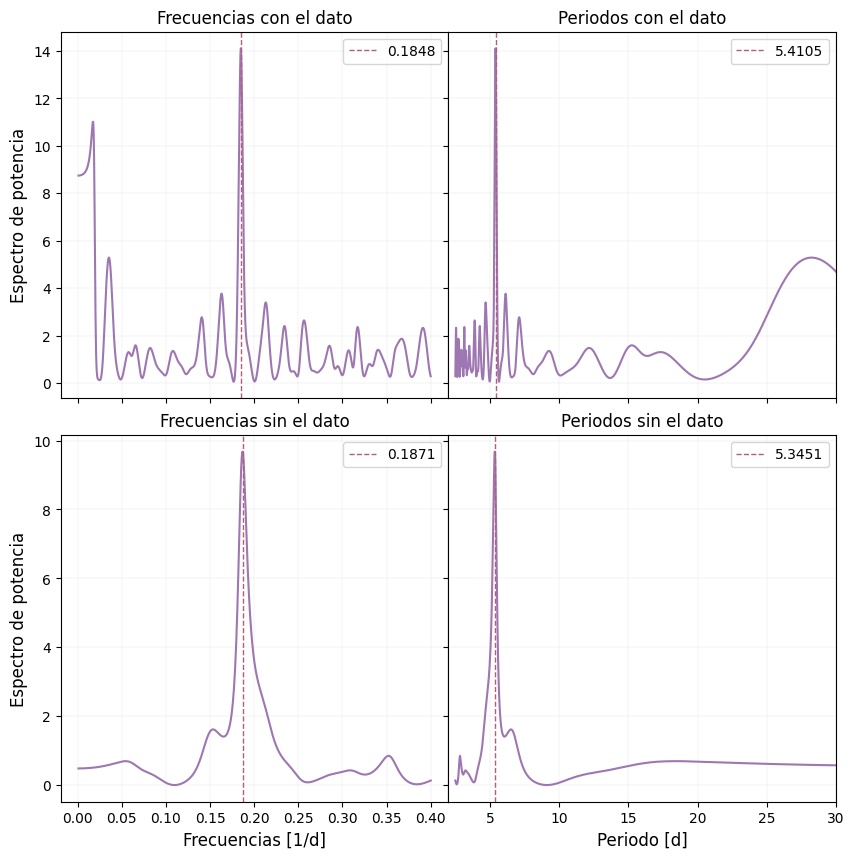

In [71]:
# Supongamos que tienes tus datos de tiempo y velocidades radiales en dos arreglos numpy, por ejemplo:
t = np.array([59616.23271964618, 59650.10320109323, 59656.0512570944, 59657.12144344438, 59658.05911761139, 59661.10135918918, 59664.12034640477, 59666.11733959911])*u.day  # Tiempo de observación
y = np.array(VR_AlxUlt)*u.km/u.s  # Velocidades radiales observadas
dy = (Err_VR_AlxUlt)*u.km/u.s

# Calcular el periodograma usando la transformada de Lomb-Scargle
frequency, power = LombScargle(t, y,dy, normalization = 'model').autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
frequency_sin, power_sin = LombScargle(t[1:], y[1:],dy[1:], normalization = 'model').autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')

print("-----------------------------------------------")
print("Poder máximo con el dato: ",max(power))
f = frequency[np.argmax(power)]
p = 1/frequency[np.argmax(power)]
print(f"Frecuencia: {f}")
print(f"Periodo: {p}")
print("-----------------------------------------------")
print("Poder máximo sin el dato: ",max(power_sin))
f_sin = frequency_sin[np.argmax(power_sin)]
p_sin = 1/frequency_sin[np.argmax(power_sin)]
print(f"Frecuencia: {f_sin} ")
print(f"Periodo: {p_sin}")
print("-----------------------------------------------")


# Graficar el periodograma
fig = plt.figure(figsize=(10,10))

gs = fig.add_gridspec(2, 2, hspace=0.1, wspace=0)
(ax1,ax2), (ax3,ax4) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Frecuencias con el dato', fontsize = 12)
ax2.set_title('Periodos con el dato', fontsize = 12)
ax3.set_title('Frecuencias sin el dato', fontsize = 12)
ax4.set_title('Periodos sin el dato', fontsize = 12)

ax1.plot(frequency, power, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax2.plot(1/frequency, power, '-',color = '#9E77B2' )  # Periodo sin el dato 
ax3.plot(frequency_sin, power_sin, '-',color = '#9E77B2' )    # Frecuencia con el dato
ax4.plot(1/frequency_sin, power_sin, '-',color = '#9E77B2' )  # Periodo sin el dato 

ax1.axvline(f.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f.value,4))
ax2.axvline(p.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p.value,4))
ax3.axvline(f_sin.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(f_sin.value,4))
ax4.axvline(p_sin.value, color = "#B15F7B", linewidth = 1., linestyle = "dashed", label = round(p_sin.value,4))


ax1.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax1.set_ylabel('Espectro de potencia',fontsize = 12)
ax2.set_xlabel('Periodo[d]',fontsize = 12)
ax2.set_ylabel('Espectro de potencia',fontsize = 12)

ax3.set_xlabel('Frecuencias [1/d]',fontsize = 12)
ax3.set_ylabel('Espectro de potencia',fontsize = 12)
ax4.set_xlabel('Periodo [d]',fontsize = 12)
ax4.set_ylabel('Espectro de potencia',fontsize = 12)

ax2.set_xlim(2,30)
ax4.set_xlim(2,30)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)


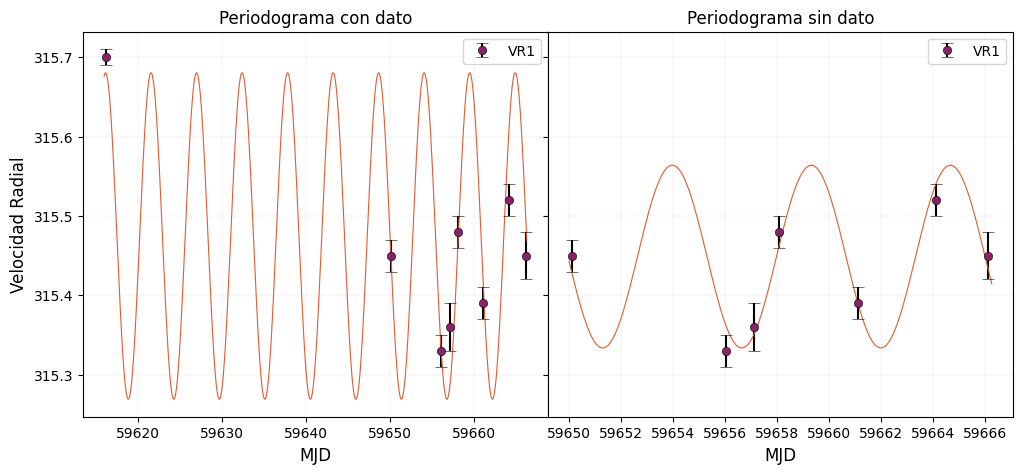

In [72]:
best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(59616,59666.25,1000)*u.day
ls = LombScargle(t, y, dy,  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit = ls.model(t_fit, best_frequency)

best_frequency_sin = frequency_sin[np.argmax(power_sin)]
t_fit_sin = np.linspace(59650,59666.25,1000)*u.day
ls_sin = LombScargle(t[1:], y[1:], dy[1:],  normalization = 'model')#.autopower(minimum_frequency=0.001*1/u.day,maximum_frequency=0.4*1/u.day,samples_per_peak=100,method='fastchi2')
y_fit_sin = ls_sin.model(t_fit_sin, best_frequency_sin)


# Graficar el periodograma
fig = plt.figure(figsize=(12,5))

gs = fig.add_gridspec(1, 2, hspace=0.1, wspace=0)
(ax1,ax2) = gs.subplots(sharex='col', sharey='row')
ax1.set_title('Periodograma con dato', fontsize = 12)
ax2.set_title('Periodograma sin dato', fontsize = 12)

ax1.plot(np.array(t_fit), np.array(y_fit), '-', color = '#e45a31', linewidth = 0.8) 
ax1.errorbar(np.array(t), y.value,  yerr = dy.value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')

ax2.plot(np.array(t_fit_sin), np.array(y_fit_sin), '-', color = '#e45a31', linewidth = 0.8)  
ax2.errorbar(np.array(t[1:]), y[1:].value,  yerr = dy[1:].value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')


ax1.set_xlabel('MJD',fontsize = 12)
ax1.set_ylabel('Velocidad Radial',fontsize = 12)
ax2.set_xlabel('MJD',fontsize = 12)
ax2.set_ylabel('Velocidad Radial',fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    #ax.set_xlim(-1.96,0.5)
    #ax.set_ylim(-0.96,3)
    ax.legend()
    ax.grid(linestyle='-', linewidth=0.1)

In [73]:
print("-"*80)
print("Valor del máximo pico: ", power.max())
print("Diferentes Métodos de 'False Alarm Approximations' con dato")
print("baluev: ",ls.false_alarm_probability(power.max(),method='baluev', maximum_frequency = frequency.max()))
print("\x1b[1;35m"+f"bootstrap: {ls.false_alarm_probability(power.max(),method='bootstrap', maximum_frequency = frequency.max())}"+"\033[0m")
print("davies: ",ls.false_alarm_probability(power.max(),method='davies', maximum_frequency = frequency.max()))
print("naive: ",ls.false_alarm_probability(power.max(), method='naive', maximum_frequency = frequency.max()))
print("-"*80)
print("Valor del máximo pico: ", power_sin.max())
print("Diferentes Métodos de 'False Alarm Approximations' sin dato")
print("baluev: ",ls_sin.false_alarm_probability(power_sin.max(),method='baluev', maximum_frequency = frequency_sin.max()))
print("\x1b[1;35m"+f"bootstrap: {ls_sin.false_alarm_probability(power_sin.max(),method='bootstrap', maximum_frequency = frequency_sin.max())}"+"\033[0m")
print("davies: ",ls_sin.false_alarm_probability(power_sin.max(),method='davies', maximum_frequency = frequency_sin.max()))
print("naive: ",ls_sin.false_alarm_probability(power_sin.max(), method='naive', maximum_frequency = frequency_sin.max()))
print("-"*80)

--------------------------------------------------------------------------------
Valor del máximo pico:  14.109173442239543
Diferentes Métodos de 'False Alarm Approximations' con dato
baluev:  0.15526885960659054
bootstrap: 0.253
davies:  0.16873624383638194
naive:  0.022188746165648664
--------------------------------------------------------------------------------
Valor del máximo pico:  9.676263470680702
Diferentes Métodos de 'False Alarm Approximations' sin dato
baluev:  0.2023907434050319
bootstrap: 0.30200000000000005
davies:  0.2260977431338634
naive:  0.05566837146758469
--------------------------------------------------------------------------------


## Prueba de modelo ajustado

In [74]:
θ = ls.model_parameters(best_frequency_sin, units=True)
θ

<Quantity [-0.05662268,  0.113975  , -0.17232256] km / s>

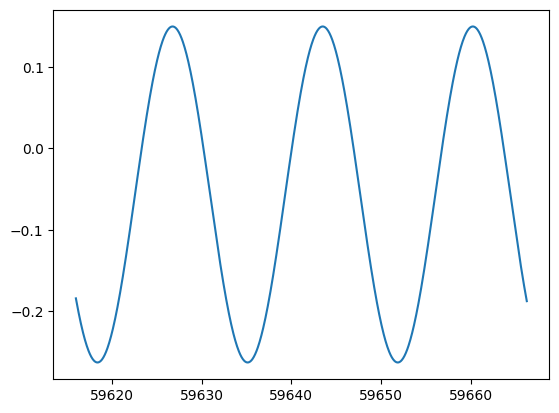

In [75]:
def y(t,f,θ):
    y = θ[0].value + (θ[1].value*np.sin(2*np.pi*f.value*t.value)+θ[2].value*np.cos(2*np.pi*f.value*t.value))
    return y

y_model = []
for i in t_fit_sin:
    y_model.append(y(i,best_frequency,θ))
    
plt.plot(np.array(t_fit), y_model)

## Simulaciones Monte Carlo:
Para darle peso a los resultados obtenidos, debido a que son pocos datos, es importante entonces realizar un proceso estadístico que me permita recrear los datos N veces, para de esta forma darle un peso mayor a los resultados obtenidos.

Primero vamos a estimar la discrepancia entre el valor que tengo como observación (medido) y el valor que me arroja el modelo. Necesitamos saber si eso fluctua gaussianamente para poder hacer, es decir, hacer un test de gaussianidad con estos valores.

### iSpec 

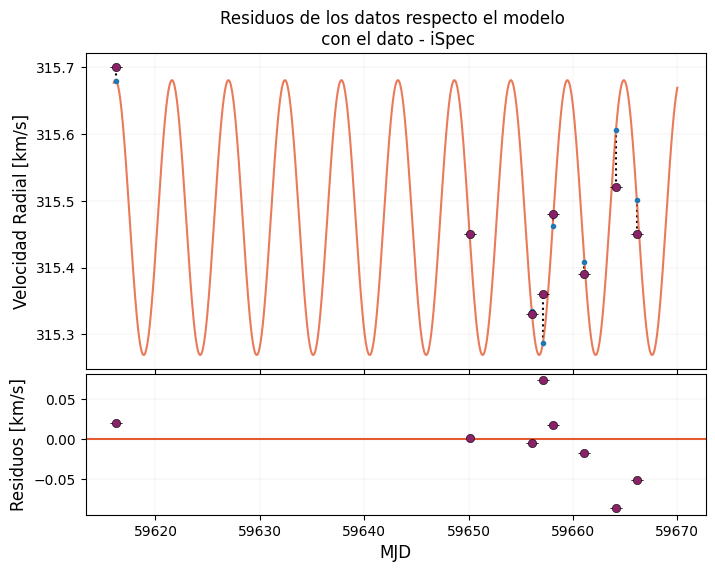

In [12]:
v_int = []
for i in t.value:
    v_int.append(np.interp(i, t_fit.value, y_fit.value))
y_new = y.value - v_int


fig, ax = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.02}
)

# Graficando los residuos.
ax[0].plot(np.array(t_fit), np.array(y_fit), '-', color = '#e45a31', markersize = 0.5, alpha=0.8) 

n  = len(t.value)

for i in range(0,n,1):
    y0 = np.min([y.value[i],v_int[i]])
    y1 = np.max([y.value[i],v_int[i]])
    ax[0].vlines(t.value[i],y0,y1, color='k',
               linestyle ='dotted')
ax[0].set_title("Residuos de los datos respecto el modelo \n con el dato - iSpec")
ax[0].plot(t, v_int,'.')
ax[0].errorbar(t.value, y.value,  yerr = 0, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')
ax[0].set_ylabel('Velocidad Radial [km/s]',fontsize = 12)

ax[1].errorbar(t.value, y_new, yerr=0,linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')
ax[1].axhline(0, color="#e45a31")
ax[1].set_xlabel('MJD',fontsize = 12)
ax[1].set_ylabel("Residuos [km/s]",fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)

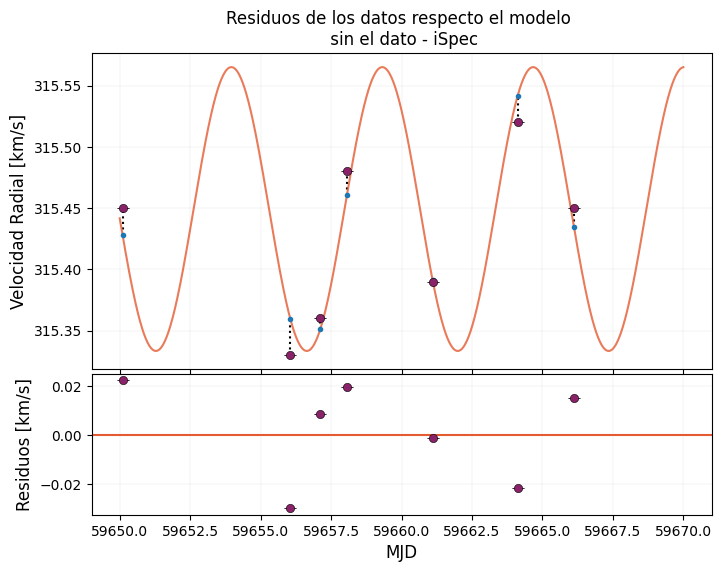

In [13]:
v_int_sin = []
for i in t[1:].value:
    v_int_sin.append(np.interp(i, t_fit_sin.value, y_fit_sin.value))
y_new_sin = y[1:].value - v_int_sin


fig, ax = plt.subplots(
    2, 1, sharex=True, figsize=(8, 6), gridspec_kw={"height_ratios": (1.8, 0.8), 'hspace': 0.02}
)

# Graficando los residuos.
ax[0].plot(np.array(t_fit_sin), np.array(y_fit_sin), '-', color = '#e45a31', markersize = 0.5, alpha=0.8) 

n  = len(t[1:].value)

for i in range(0,n,1):
    y0_sin = np.min([y[1:].value[i],v_int_sin[i]])
    y1_sin = np.max([y[1:].value[i],v_int_sin[i]])
    ax[0].vlines(t[1:].value[i],y0_sin,y1_sin, color='k',
               linestyle ='dotted')
ax[0].set_title("Residuos de los datos respecto el modelo \n sin el dato - iSpec")
ax[0].plot(t[1:], v_int_sin,'.')
ax[0].errorbar(t[1:].value, y[1:].value,  yerr = 0, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')
ax[0].set_ylabel('Velocidad Radial [km/s]',fontsize = 12)

ax[1].errorbar(t[1:].value, y_new_sin, yerr=0,linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#8a226a',mec='k', ms=6, mew=0.4, label ='VR1')
ax[1].axhline(0, color="#e45a31")
ax[1].set_xlabel('MJD',fontsize = 12)
ax[1].set_ylabel("Residuos [km/s]",fontsize = 12)

for ax in fig.get_axes():
    ax.label_outer()
    ax.grid(linestyle='-', linewidth=0.1)


In [14]:
np.min([v_int[0],y_fit.value[0]])

315.67654525761594

Supongamos que deseamos probar la hipótesis nula de que las diferencias vienen de la misma distribución (distribución normal). Elegimos un nivel de confianza del 95%; es decir, rechazaremos la hipótesis nula a favor de la alternativa si el valor p es menor que 0,05.

In [17]:
y_new = y.value - v_int
print(y_new)

mu, sigma = 0, 1 # media y desviación estándar
num_samples = len(y_new) # usar la misma cantidad de muestras que tu conjunto de datos

# Generar una muestra de datos de la distribución normal
normal_data = np.random.normal(mu, sigma, 1000000)
print("k test para datos de la diferencia entre el dato y la función: \n",ks_2samp(y_new, normal_data))

[ 0.02014866  0.00144825 -0.00450435  0.07281133  0.01756121 -0.01806274
 -0.08630195 -0.05126656]
k test para datos de la diferencia entre el dato y la función: 
 KstestResult(statistic=0.472128, pvalue=0.03706339685528215, statistic_location=0.07281133423060737, statistic_sign=1)


Según esto, el p-value encontrado es 0.22 que es mayor a 0.05, es decir que no rechazamos la hipótesis nula.

In [18]:
stats.kstest(y_new, "norm")

KstestResult(statistic=0.4709781257435346, pvalue=0.037799464173166375, statistic_location=0.07281133423060737, statistic_sign=1)

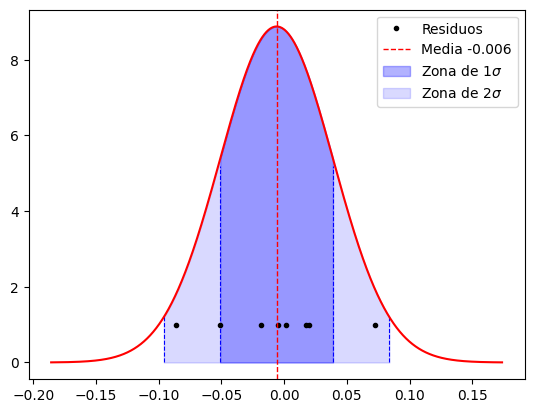

In [19]:
plt.plot(y_new,[1,1,1,1,1,1,1,1], '.', color = 'k', label = 'Residuos')
media = np.mean(y_new)  # Media del ruido
σ =np.sqrt(np.var(y_new))  # Desviación estándar del ruido
# Generar el ruido gaussiano
x=np.linspace(-4*σ+media,4*σ+media,num=100000)
y=stats.norm.pdf(x,media,σ)

plt.plot(x,y,'r')
plt.axvline(media, color = "red", linewidth = 1, linestyle = "dashed", label = f'Media {round(media,4)}')

x_1s = np.linspace(-1*σ+media,1*σ+media,num=100000)
y_1s = stats.norm.pdf(x_1s,media,σ)
plt.fill_between(x_1s,y_1s, color = 'b', alpha=0.3,label='Zona de $1\sigma$')
plt.vlines(x=-1*σ+media, ymin=0, ymax=5.2, linestyles ='--', color = 'b', linewidth = 0.8)
plt.vlines(x=1*σ+media, ymin=0, ymax=5.2, linestyles ='--', color = 'b', linewidth = 0.8)

x_2s = np.linspace(-2*σ+media,2*σ+media,num=100000)
y_2s = stats.norm.pdf(x_2s,media,σ)
plt.fill_between(x_2s,y_2s, color = 'b', alpha=0.15,label='Zona de $2\sigma$')
plt.vlines(x=-2*σ+media, ymin=0, ymax=1.25, linestyles ='--', color = 'b', linewidth = 0.8)
plt.vlines(x=2*σ+media, ymin=0, ymax=1.25, linestyles ='--', color = 'b', linewidth = 0.8)



plt.legend()

In [20]:
print("La desviación estándar estimada es: ", σ)

La desviación estándar estimada es:  0.0449316042594321


In [21]:

# Tu conjunto de datos original (por ejemplo)
datos_originales = y_fit  # Inserta tus datos reales aquí
tiempos_originales = t_fit

# Número de experimentos de Monte Carlo
num_experimentos = 100000

# Número de puntos en cada experimento
num_puntos = 8

# Generar N experimentos de Monte Carlo
experimentos_mc = []
tiempos_mc = []

for _ in tqdm(range(num_experimentos)):
    # Seleccionar aleatoriamente 8 puntos del conjunto de datos original
    indices_aleatorios = np.random.choice(len(datos_originales), size=num_puntos, replace=False)
    datos_experimento = datos_originales[indices_aleatorios]
    experimentos_mc.append(datos_experimento)

    # Agregando los tiempos aleatorios  
    #indices_aleatorios = np.random.choice(len(tiempos_originales), size=num_puntos, replace=False)
    tiempos_experimento = tiempos_originales[indices_aleatorios]
    tiempos_mc.append(tiempos_experimento)

# Convertir la lista de experimentos en un arreglo numpy
experimentos_mc = np.array(experimentos_mc)
tiempos_mc = np.array(tiempos_mc)

# Verificar la forma de los datos generados
print("Forma de los datos generados:", experimentos_mc.shape)
print("Forma de los datos de tiempo generados:", tiempos_mc.shape)


100%|████████████████████████████████| 100000/100000 [00:05<00:00, 17264.89it/s]


Forma de los datos generados: (100000, 8)
Forma de los datos de tiempo generados: (100000, 8)


In [22]:


#t = np.array([ 59616.23271964618, 59650.10320109323, 59656.0512570944, 59657.12144344438, 59658.05911761139, 59661.10135918918, 59664.12034640477, 59666.11733959911])*u.day  # Tiempo de observación
dy = ([0.01,0.02,0.02,0.03,0.02,0.02,0.02,0.03])*u.km/u.s

f_montecarlo = []
p_montecarlo = []
FAP = []

for i in tqdm(range(len(experimentos_mc))):
    # Parámetros del ruido gaussiano
    media = 0  # Media del ruido
    desviacion_estandar = σ
  # Desviación estándar del ruido
    
    # Generar el ruido gaussiano
    ruido = np.random.normal(media, desviacion_estandar, num_puntos)
    
    # Agregar el ruido a la señal
    experimentos_mc_ruido = experimentos_mc[i] + ruido

    t = tiempos_mc[i]*u.d
    y = experimentos_mc_ruido*u.km/u.s
    frequency, power = LombScargle(t, y,normalization='model').autopower(minimum_frequency=0.02*1/u.day,maximum_frequency=0.22*1/u.day,samples_per_peak=100,method='fastchi2')
#
    f_montecarlo.append(frequency[np.argmax(power)])
    p_montecarlo.append(1/frequency[np.argmax(power)])

    # best_frequency = frequency[np.argmax(power)]
    # t_fit = np.linspace(59616,59666.25,1000)*u.day
    # ls = LombScargle(t, y, dy, fit_mean=True, center_data=True,normalization='model')
    # y_fit = ls.model(t_fit, best_frequency)
    # FAP.append(ls.false_alarm_probability(power.max(),method='bootstrap', maximum_frequency = frequency.max()))


100%|███████████████████████████████████| 100000/100000 [45:56<00:00, 36.28it/s]


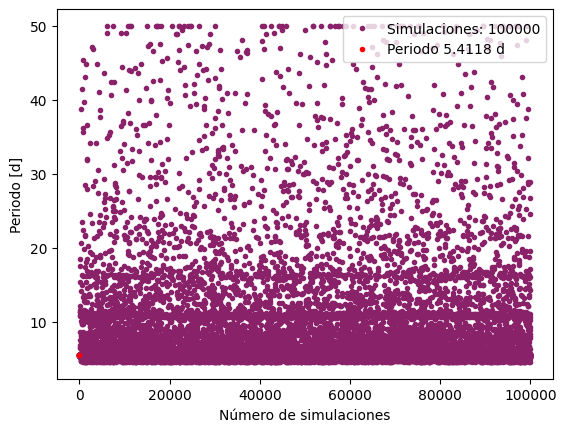

In [32]:
periodos_monte_carlo = [dato.value for dato in p_montecarlo]

#plt.ylim(0,30)
plt.plot(periodos_monte_carlo,'.',color = '#8a226a', label = f'Simulaciones: {len(periodos_monte_carlo)}')
plt.plot(p, '.', color = 'r',  label = f'Periodo {np.round(p,4)}')
plt.xlabel("Número de simulaciones")
plt.ylabel("Periodo [d]")
plt.legend()

In [26]:
nuevos_p_monte_carlo = []
nueva_FAP = []

for i in range(len(periodos_monte_carlo)):
    if periodos_monte_carlo[i] <= 50:
        nuevos_p_monte_carlo.append(periodos_monte_carlo[i])
        #nueva_FAP.append(FAP[i])


In [27]:
print("Simulaciones aceptadas: ",len(nuevos_p_monte_carlo))

Simulaciones aceptadas:  100000


In [28]:
def doane_bins(datos):
    """
    Calcula el número de bins para un histograma utilizando la regla de Doane.
    La regla de Doane ajusta el número de bins para tener en cuenta el sesgo (skewness) de la distribución de los datos.
    Parámetros:
    -----------
    datos : array-like
        Los datos de los cuales se desea calcular el número de bins.
    Retorna:
    --------
    numero_bins : int
        El número de bins calculado según la regla de Doane.
    """
    datos = np.asarray(datos)
    n = len(datos)
    skewness = stats.skew(datos)
    se_skewness = np.sqrt((6 * (n - 2)) / ((n + 1) * (n + 3)))
    numero_bins = 1 + math.log2(n) + math.log2(1 + (abs(skewness) / se_skewness))
    return int(numero_bins)

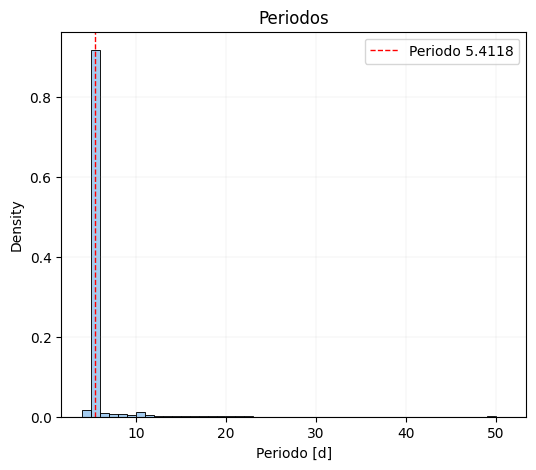

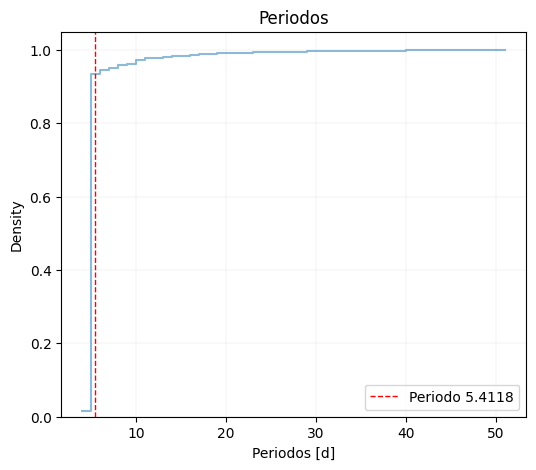

In [29]:
dist = np.array(nuevos_p_monte_carlo)
dist = pd.Series(dist, name = "Numerical Variable")

plt.figure(figsize=(6,5))
plt.xlabel('Periodo [d]')
#plt.ylabel('Velocidad Radial')
plt.title('Periodos')
sns.histplot(dist,stat='density', bins = doane_bins(dist),alpha=0.5, cumulative=False, element='bars', discrete = True, color = '#4B9BE2')
plt.axvline(p.value, color = "red", linewidth = 1, linestyle = "dashed", label = f'Periodo {round(p.value,4)}')
#dist.plot.kde(color = '#8a226a', linewidth = 1)
#plt.xlim(0,40)
plt.grid(linestyle='-', linewidth=0.1)
plt.legend()
plt.show()

#Valor fijo para los bins

plt.figure(figsize=(6,5))
plt.xlabel('Periodos [d]')
plt.ylabel('')
plt.title('Periodos')
sns.histplot(dist,stat='density', bins = doane_bins(dist),alpha=0.5, cumulative=True, element='step', fill = False, discrete = True)
plt.axvline(p.value, color = "red", linewidth = 1, linestyle = "dashed", label = f'Periodo {round(p.value,4)}')
plt.legend()
plt.grid(linestyle='-', linewidth=0.1)
plt.show()


# dist = np.array(nueva_FAP)
# plt.figure(figsize=(6,5))
# plt.xlabel('Values')
# #plt.ylabel('Velocidad Radial')
# plt.title('FAP (Probabilidad de Falsa Alarma)')
# sns.histplot(dist, bins = 50,alpha=0.5)
# plt.grid(linestyle='-', linewidth=0.1)
# plt.show()

In [30]:
# Poner en el mismo grafico 

In [31]:
stats.mode(dist)

/tmp/ipykernel_3976/2325272287.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode(dist)


ModeResult(mode=array([5.40540541]), count=array([103]))

In [58]:
# Periodo real
periodo_real = p.value #p.value  # Reemplaza con tu período real

# Períodos obtenidos en los experimentos de Monte Carlo
# Supongamos que tienes un arreglo numpy con los períodos obtenidos en los 10,000 experimentos
# periodos_monte_carlo = np.array([...])

# Calcular la media y la desviación estándar de los períodos obtenidos en los experimentos
media_periodos = np.mean(nuevos_p_monte_carlo)
desviacion_estandar_periodos = np.std(nuevos_p_monte_carlo)

print(media_periodos)
print(desviacion_estandar_periodos)
# Calcular el intervalo de confianza al 95% de los períodos obtenidos en los experimentos
intervalo_confianza = norm.interval(0.95, loc=media_periodos, scale=desviacion_estandar_periodos)
# print(intervalo_confianza[0])
# print(intervalo_confianza[1])
# Verificar si el periodo real está dentro del intervalo de confianza
if intervalo_confianza[0] <= periodo_real <= intervalo_confianza[1]:
    print("El periodo real está dentro del intervalo de confianza.")
else:
    print("El periodo real está fuera del intervalo de confianza.")

# Calcular la probabilidad de que el periodo real esté dentro del intervalo de confianza
# Calcula la probabilidad de que una variable aleatoria X sea menor o igual que x. Matemáticamente, se escribe P(X <= x).
probabilidad_cdf = norm.cdf(periodo_real, loc=media_periodos, scale=desviacion_estandar_periodos)
print("La probabilidad de que el periodo real esté dentro del intervalo de confianza es:", probabilidad_cdf) 
# probabilidad_pdf = norm.pdf(periodo_real, loc=media_periodos, scale=desviacion_estandar_periodos)
# print("La probabilidad de que el periodo real esté dentro del intervalo de confianza es:", probabilidad_pdf)


5.936491685837367
3.067333872528344
El periodo real está dentro del intervalo de confianza.
La probabilidad de que el periodo real esté dentro del intervalo de confianza es: 0.4320934616007019


In [187]:
from scipy.stats import kstest
import numpy as np
from scipy.stats import ks_2samp

y_CERES = np.array([315.6384, 315.535700,315.577800,315.596800,315.578100,315.531800,315.505200,315.541700])*u.km/u.s  # Velocidades radiales observadas
dy_CERES = [0.013000, 0.009800,0.011400,0.013600,0.009100,0.012000,0.010200,0.011800]*u.km/u.s
y_iSpec = np.array([315.70, 315.45, 315.33, 315.36, 315.48, 315.39, 315.52, 315.45])*u.km/u.s  # Velocidades radiales observadas
dy_iSpec = ([0.01, 0.02,0.02,0.03,0.02,0.02,0.02,0.03])*u.km/u.s

print("CERES: ",ks_2samp(y_CERES.value, 'norm'))
print("dy CERES: ",ks_2samp(dy_CERES.value, 'norm'))
print("iSpec: ",ks_2samp(y_iSpec.value, 'norm'))
print("dy iSpec: ",ks_2samp(dy_iSpec.value, 'norm'))

print("Comparación : ",ks_2samp(y_CERES.value, y_iSpec.value))


CERES:  KstestResult(statistic=1.0, pvalue=0.2222222222222222, statistic_location='315.6384', statistic_sign=1)
dy CERES:  KstestResult(statistic=1.0, pvalue=0.2222222222222222, statistic_location='0.0136', statistic_sign=1)
iSpec:  KstestResult(statistic=1.0, pvalue=0.2222222222222222, statistic_location='315.7', statistic_sign=1)
dy iSpec:  KstestResult(statistic=1.0, pvalue=0.2222222222222222, statistic_location='0.03', statistic_sign=1)
Comparación :  KstestResult(statistic=0.75, pvalue=0.018648018648018645, statistic_location=315.48, statistic_sign=-1)


## Otra prueba

In [90]:
# import scipy.signal as signal
# nout = 100000
# w = np.linspace(0.05, 2, nout)
# pgram = signal.lombscargle(t, y, w,normalize=True)

In [91]:
# fig, (ax_t, ax_w) = plt.subplots(2, 1, constrained_layout=True)
# ax_t.plot(t, y, 'b+')
# ax_t.set_xlabel('Time [d]')
# ax_w.plot(w, pgram)
# ax_w.set_xlabel('Angular frequency [rad/d]')
# ax_w.set_ylabel('Normalized amplitude')
# plt.show()

In [92]:
# print(w[np.argmax(pgram)],1/w[np.argmax(pgram)])

In [93]:
# best_frequency = w[np.argmax(pgram)]*1/u.day
# t_fit = np.linspace(59616,59666.25,1000)*u.day
# ls = LombScargle(t, y, dy)
# y_fit = ls.model(t_fit, best_frequency)

# plt.figure(figsize=(6,5))
# plt.plot(np.array(t_fit), y_fit, '-', color = '#9E77B2', linewidth = 0.8)  # Frecuencia angular a período
# x = [59616.23271964618, 59650.10320109323, 59656.0512570944, 59657.12144344438, 59658.05911761139, 59661.10135918918, 59664.12034640477, 59666.11733959911]

# plt.errorbar(x, y.value,  yerr = dy.value, linestyle="None",  fmt="o",  capsize=4,  ecolor="k", mfc='#B5C99A',mec='k', ms=6, mew=0.4, label ='VR1')
# plt.xlabel('Fase')
# plt.ylabel('Velocidad Radial')
# plt.title('Periodograma de Velocidades Radiales')
# plt.grid(linestyle='-', linewidth=0.2)
# plt.legend()
# plt.show() 

## Otra prueba

In [94]:
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt

# # use seaborn's default plotting styles for matplotlib


In [95]:
# def freq_grid(t, oversampling=5, nyquist_factor=3):
#     T = t.max() - t.min()
#     N = len(t)
    
#     df = 1. / (oversampling * T)
#     fmax = 0.5 * nyquist_factor * N / T
#     N = int(fmax // df)
#     return df + df * np.arange(N)

In [96]:
# freq = freq_grid(t, nyquist_factor=10)
# print(len(freq))

In [97]:
# from gatspy.periodic import LombScargle
# model = LombScargle().fit(t, y, dy)
# period = 1. / freq
# power = model.periodogram(period)
# print(period[np.argmax(power)])

# plt.plot(period, power)
# plt.xlim(4, 12);

## Masa del objeto en la órbita Kepleriana

En el artículo se supone una masa de $M = 1.6 M☉$ o $M = 0.8 M☉$  para HD 55496 (la baja metalicidad sugiere una naturaleza antigua, por lo tanto, de menor masa).

In [174]:
def Masas(P):
    G = 6.67e-11          # m³/kgs²
    VR = np.mean(y.value) # km/s
    P = P*86400     # s
    a = (VR*P)/(2*np.pi) * 1000 # m
    M = (4*np.pi*a**3)/(P**2*G) # M = M1+M2 kg
    M = M/1.989e+30 #M☉
    # Si M = 0.8 M☉
    M1 = 1.6 #0.8 #M☉
    M2 = M-M1
    return M2,a # En masas solares

print('Con un periodo de',2.7,'días, se obtiene una masa de', Masas(2.7)[0],'M☉',format(Masas(5.4105)[1]/1000,".1E"),'km',format(Masas(5.4105)[1]/1000/1.496e+8,".2"), 'UA')
print('Con un periodo de',5.4105,'días, se obtiene una masa de', Masas(5.4105)[0],'M☉',format(Masas(5.4105)[1]/1000,".1E"),'km',format(Masas(5.4105)[1]/1000/1.496e+8,".2"), 'UA')
print('Con un periodo de',10.4802,'días, se obtiene una masa de', Masas(10.4802)[0],'M☉',format(Masas(10.4802)[1]/1000,".1E"),'km',format(Masas(10.4802)[1]/1000/1.496e+8,".2"), 'UA')


Con un periodo de 2.7 días, se obtiene una masa de 1.1976327546110275 M☉ 2.3E+07 km 0.16 UA
Con un periodo de 5.4105 días, se obtiene una masa de 4.006145192156655 M☉ 2.3E+07 km 0.16 UA
Con un periodo de 10.4802 días, se obtiene una masa de 9.259166961064631 M☉ 4.5E+07 km 0.3 UA


Los resultados son interesantes, porque según las simulaciones que he hechom los valores obtenidos para el periodo son principalmente como si fueran multiplos, es decir. 
Por un lado se obtienen picos de cuenta de datos del periodo en aproximadamente 2.5, 5, 10, 20, 40 días, es como si fueran multiplos, y en principio hay mayor probabilidad de que se obtenga un periodo más bajo que en el caso de un periodo grande, en cualquiera de los casos, es bastante interesante, porque las masas dan bastante realistas.

#### Análisis
Teniendo en cuenta que en el artículo se hace una estimación de la posibles masas que tendrían las estrellas que enriquecieron a HD 55496 en un cúmulo globular, entonces podemos ver lo siguiente:

"como lo sugiere la sobreabundancia de sodio y aluminio, también es posible que estrellas AGB de masa intermedia entre 4.0 y 6.0 M☉, fueran respondables de la producción de los elementos creados por el proceso s durante el tiempo de formación de HD 55496 en un cúmulo globular" 

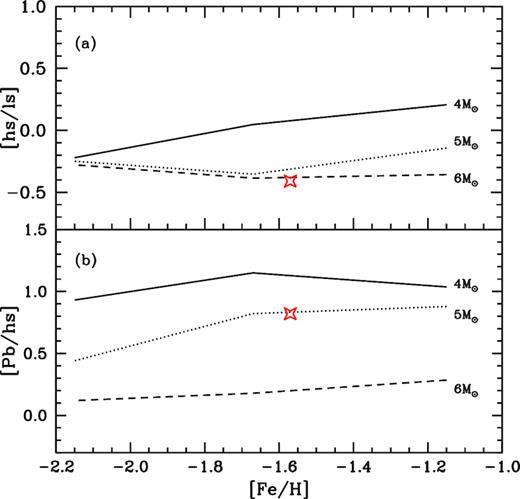

*Relación [hs/ls] versus [Fe/H] (a) y relación [Pb/hs] versus [Fe/H] (b) para HD 55496 en comparación con las predicciones del modelo AGB dadas por Cristallo et al. ( 2015 ) para estrellas AGB con masas de 4,0, 5,0 y 6,0 M⊙ .*

De alguna manera si miramos, el resultado obtenido con el periodo de 5.41 días, que sugiere que si tengo una estrella de 0.8 M☉ la otra debería tener 4.8 M☉, lo que concuerda con el hecho de las masas de estrellas que pudieron haber enriquecido a HD 55496 en el caso hipotético de provenir de un cúmulo globular.

<span style="color:red">*Sin embargo, mi pregunta es, tendría sentido que no detectemos una estrella tan masiva (4.8 M☉) en el espectro, o en el cálculo de la velocidad radial ?*</span>.


<span style="color:blue">*Si confirmamos con un poco de significancia el potencial evento periodico que aparece, vale la pena explorar la posibilidad de un objeto compacto muy cerca según los datos, con inclinación cero, la situación más ideal posible, hay un par ahí, pero no estamos viendo la compañera. 
El comportamiento de la estrella es muy raro, el enriquecimiento se puede explicar por medio de que hizo parte de un par binario compacto, la estrella evolucionó y evidentemente la anomalía química proviene precisamente del enriquecimiento de evolución estelar en el par binario.*</span>

**Óptico.**

![](ESASky_optico.png)

**Infrarrojo cercano (2MASS color JHK).**

![](ESASky_Infrarrojo_cercano.png)

**Infrarrojo medio (AIIWISE color).**

![](ESASky_Infrarrojo_medio.png)
